# Dataset cross-validation experiment

In [ ]:
!pip install xgboost

In [1]:
import glob
import imageio
import os
import pandas
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
import random
import scipy.stats
import shutil
import skimage.filters
import skimage.segmentation
import sklearn
import train_utils
import xgboost as xgb
import re

from functools import partial
from itertools import groupby
from notebook_utils import *
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import GroupKFold, StratifiedKFold, GroupShuffleSplit, LeavePGroupsOut, KFold, StratifiedShuffleSplit, LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import plot_importance

from dataset import DatasetBase
# from benchmark import BenchmarkModel

importlib.reload(train_utils);
py.offline.init_notebook_mode(connected=True)
%matplotlib inline

SEED = 42

In [2]:
def drop_patient_3(dataset, label='TestNewClasses S3'):
    """Drop patient - values are uncertain/missleading due tu poor aqusition"""
    drop_mask = [label in idx[0] for idx in dataset.index]
    return dataset.drop(dataset.index[drop_mask])

def drop_patient_1(dataset, label='TestNewClasses S1'):
    drop_mask = [label in idx[0] for idx in dataset.index]
    return dataset.drop(dataset.index[drop_mask])

def drop_patient_2(dataset, label='TestNewClasses S2'):
    drop_mask = [label in idx[0] for idx in dataset.index]
    return dataset.drop(dataset.index[drop_mask])

In [3]:
def add_patient_no_column(dataset):
    """Adds `patient_number` column"""
    patient_label = [re.search(r"S(\d+)", idx[0]).group(1) for idx in cd8_data.index]
    dataset['patient_number'] = patient_label
    return dataset

In [4]:
def test_if_image_split_not_overlap(dataset, train_idxs, test_idnx):
    """Check if groups overlap in test/train set. 
    
    Args:
        dataset (DatasetBase): instance of DatasetBase
        train_idxs: (np.array): array of train rows from given dataframe(DatasetBase)
        test_idxs: (np.array): array of test rows from given dataframe(DatasetBase)
    """
    train = ds.data.iloc[train_idxs, :]
    train_images = set(train.groupby(level=[0]).groups.keys())
    
    test = ds.data.iloc[test_idxs, :]
    test_images = set(test.groupby(level=[0]).groups.keys())
    assert len(test_images.intersection(train_images)) == 0

In [5]:
def group_by_image(dataset):
    """Return mapping of image. Required for crossvalidation"""
    return [idx[0] for idx in dataset.index]

def group_by_patient(dataset):
    """Return mapping of patient. Required for crossvalidation"""
    return [re.search(r'S(\d+)', idx[0]).group(1) for idx in dataset.index]    

In [6]:
def print_scores(name, scores):
    """Print basic score info
    
    Args:
        name (str): Name of score/CrossVal method
        scores (dict): Score dict
    """
    s = "%s F-score: %0.2f (+/- %0.2f), Precision: %0.2f (+/- %0.2f), Recall: %0.2f (+/- %0.2f)"
    print(s % (name,
               scores['test_f1'].mean(),
               scores['test_f1'].std() * 2,
               scores['test_precision'].mean(),
               scores['test_precision'].std() * 2,
               scores['test_recall'].mean(), 
               scores['test_recall'].std() * 2))

### Dataset setup

In [7]:
path_to_data = r"Precomputed/model8/ov_0.5/resize"

cd8_path = os.path.join(path_to_data, "all_features_resize_cd8.tsv")
pdl1_path = os.path.join(path_to_data, "all_features_resize_pdl1.tsv")
cd8_data = pandas.read_csv(cd8_path, sep='\t', index_col=[0,1])
pdl1_data = pandas.read_csv(pdl1_path, sep='\t', index_col=[0,1])

In [8]:
ds = DatasetBase(cd8_data, filters=[drop_patient_3])

In [9]:
SPLIT_NO = 5
TEST_SIZE = 0.2
SCORES_LIST = ['precision', 'recall', 'f1', 'average_precision']

base_feature_list = train_utils.get_feature_columns(ds.dataset.columns, 'perc_per_10', ['0','0-clahe','0-edges','0-memb','2','2-clahe','2-edges','2-memb'])
ds.set_features(base_feature_list)

### Model zoo setup

In [10]:
models = {}

baseline_model_params = {'n_estimators' : 300, 'class_weight': 'balanced', 'min_samples_leaf': 4, 'random_state': SEED, 'n_jobs': -1}
rf_tuned_params = {'criterion': 'entropy', 'n_estimators': 400, 'min_samples_leaf': 2, "max_depth": 7, 'n_jobs': -1, 'random_state': SEED}
xgb_tuned_params = {'silent': False, 'scale_pos_weight': 1, "learning_rate": 0.01, "colsample_bytree": 0.4,
                    'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 300, 'reg_alpha': 0.3,
                    'max_depth': 4, 'gamma': 4, 'random_state': SEED}

models['baseline'] = RandomForestClassifier(**baseline_model_params)
models['rf_tuned'] = RandomForestClassifier(**rf_tuned_params)
models['xgb'] = xgb.XGBClassifier(objective="binary:logistic", random_state=SEED)
models['xgb_tuned'] = xgb.XGBClassifier(**xgb_tuned_params)

## Evaluate split by image

In [11]:
kf   = KFold(n_splits=SPLIT_NO, random_state=SEED)
skf  = StratifiedKFold(n_splits=SPLIT_NO, random_state=SEED)
gkf  = GroupKFold(n_splits=SPLIT_NO)
lpgo = LeavePGroupsOut(n_groups=3)  # time consuming 
gss  = GroupShuffleSplit(n_splits=SPLIT_NO, test_size=TEST_SIZE, random_state=SEED)

cross_val_per_image_full = {
    'KFold': kf,
    'StratifiedKFold': skf,
    'GroupKFold': gkf,
    'LeavePGroupsOut': lpgo,
    'GroupShuffleSplit': gss,
}

cross_val_per_image = {
    'KFold': kf,
    'StratifiedKFold': skf,
    'GroupKFold': gkf,
    'GroupShuffleSplit': gss,
}

cross_val_not_grouped = {
    'KFold': kf,
    'StratifiedKFold': skf,
}


### Per Image results

Per image results indicate that each image has different statistiscs. 
All models have significent decrease in scores when comparing cross-validation that take into account groups

Baseline model

In [12]:
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image_full[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.9s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.7s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.0s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.5s remaining:   20.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished


In [13]:
for name, scores in cv_image_results.items():
    print_scores(name, scores)

KFold F-score: 0.57 (+/- 0.08), Precision: 0.61 (+/- 0.11), Recall: 0.55 (+/- 0.08)
StratifiedKFold F-score: 0.58 (+/- 0.10), Precision: 0.63 (+/- 0.09), Recall: 0.55 (+/- 0.11)
GroupKFold F-score: 0.44 (+/- 0.22), Precision: 0.45 (+/- 0.29), Recall: 0.51 (+/- 0.32)
GroupShuffleSplit F-score: 0.45 (+/- 0.24), Precision: 0.53 (+/- 0.19), Recall: 0.39 (+/- 0.26)


RandomForest tuned

In [14]:
cv_image_results_rf_tuned = {}
for cv in cross_val_per_image:
    cv_image_results_rf_tuned[cv] = cross_validate(models['rf_tuned'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.0s remaining:   37.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.9s remaining:   37.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.8s remaining:   37.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.6s remaining:   35.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished


In [15]:
for name, scores in cv_image_results_rf_tuned.items():
    print_scores(name, scores)

KFold F-score: 0.50 (+/- 0.08), Precision: 0.73 (+/- 0.09), Recall: 0.38 (+/- 0.10)
StratifiedKFold F-score: 0.50 (+/- 0.08), Precision: 0.73 (+/- 0.08), Recall: 0.38 (+/- 0.09)
GroupKFold F-score: 0.39 (+/- 0.23), Precision: 0.58 (+/- 0.43), Recall: 0.39 (+/- 0.39)
GroupShuffleSplit F-score: 0.37 (+/- 0.30), Precision: 0.65 (+/- 0.24), Recall: 0.27 (+/- 0.27)


XGBoost

In [16]:
cv_image_results_xgb = {}
for cv in cross_val_per_image:
    cv_image_results_xgb[cv] = cross_validate(models['xgb'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.4s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.2s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   11.9s


KeyboardInterrupt: 

In [ ]:
for name, scores in cv_image_results_xgb.items():
    print_scores(name, scores)

XGBoost Tuned

In [ ]:
cv_image_results_xgb_tuned = {}
for cv in cross_val_per_image:
    cv_image_results_xgb_tuned[cv] = cross_validate(models['xgb_tuned'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
for name, scores in cv_image_results_xgb_tuned.items():
    print_scores(name, scores)

### Investigate group score decrease

In [ ]:
logo = LeaveOneGroupOut()

In [ ]:
# samples in form of list to track back to group 
grouped_samples = list(logo.split(X=ds.data, y=ds.data_cls, groups=group_by_image(ds.data)))

In [ ]:
score = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=grouped_samples, scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
print_scores('investiagion', score)

In [ ]:
for i, _ in enumerate(score['test_f1']):
    print('F1: %0.2f, Precision: %0.2f, Recall: %0.2f' % (score['test_f1'][i], score['test_precision'][i], score['test_recall'][i]))

In [ ]:
# filter images with f1 <= 0.4
low_f1 = score['test_f1'] <= 0.4 
test_ds_idxs = low_f1.nonzero()[0].tolist() # indexes of test_datasets from grouped_samples

In [ ]:
def map_grouped_test_set_to_images(groups_of_interest, grouped_train_test_ds, dataset):
    """Maps outcome of cross-validation on grouped test/train set
    
    Args:
        groups_of_interest (list): list of indexes of test_sets in dataset to fetch group
        grouped_train_test_ds (list): list of (train_set, test_set)
        dataset (pd.DataFrame): Original dataset from which `grouped_train_test_ds` was created
        
    Return:
        Dict of test_set_index: groups from which it was created
    """
    mapping = {}
    for idx in groups_of_interest:
        test_df = dataset.iloc[grouped_train_test_ds[idx][1], :]
        mapping[idx] = list(test_df.groupby(level=[0]).groups.keys())
    return mapping

### Problematic images

list of images removed from dataset to improve scoring. Tests indicate that these images cause problems during training / testing

In [13]:
problematic_images = map_grouped_test_set_to_images(test_ds_idxs, grouped_samples, ds.data)

NameError: name 'map_grouped_test_set_to_images' is not defined

In [ ]:
# Images with poor score
problematic_images

### Dataset split - investigate OK / NOK ds

Create two additional datasets to verify how models will behave on them.
Assumtion is that NOK dataset will score much lower then OK dataset.
OK dataset is created by removing samples from images that have poor f1 score in LeaveOne test
NOK is complementary to OK (consist problematic_images)

In [ ]:
index_name_to_drop = [idx[0] for idx in problematic_images.values()]
problematic_images_complement = set(ds.data.index.levels[0])
index_name_to_drop_problematic = problematic_images_complement.difference(set(index_name_to_drop))

ds_ok = DatasetBase(cd8_data.drop(index=index_name_to_drop), filters=[drop_patient_3])
ds_ok.set_features(base_feature_list)
ds_nok = DatasetBase(cd8_data.drop(index=index_name_to_drop_problematic), filters=[drop_patient_3])
ds_nok.set_features(base_feature_list)

In [ ]:
ds_ok_results = {}
for cv in cross_val_per_image:
    ds_ok_results[cv] = cross_validate(models['baseline'], X=ds_ok.data, y=ds_ok.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds_ok.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
# Results of OK dataset. Improvment is visible for both grouped and random splits
for name, scores in ds_ok_results.items():
    print_scores(name, scores)

In [ ]:
score = cross_validate(models['baseline'], X=ds_ok.data, y=ds_ok.data_cls, cv=logo, groups=group_by_image(ds_ok.data),  scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
# Slight improvment in leave one out.
print_scores('logo', score)

In [ ]:
groups_no = len(index_name_to_drop)
kf_prob   = KFold(n_splits=groups_no, random_state=SEED)
skf_prob  = StratifiedKFold(n_splits=groups_no, random_state=SEED)
gkf_prob  = GroupKFold(n_splits=groups_no)
gss_prob  = GroupShuffleSplit(n_splits=groups_no, test_size=TEST_SIZE, random_state=SEED)

cross_val_per_image_prob = {
    'KFold': kf_prob,
    'StratifiedKFold': skf_prob,
    'GroupKFold': gkf_prob,
    'GroupShuffleSplit': gss_prob,
}

In [ ]:
ds_nok_results = {}
for cv in cross_val_per_image_prob:
    ds_nok_results[cv] = cross_validate(models['baseline'], X=ds_nok.data, y=ds_nok.data_cls, cv=cross_val_per_image_prob[cv], groups=group_by_image(ds_nok.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
# results of NOK Dataset. Decrease in score. Gropued CV indicate that there are still images that add a lot of noise to results
for name, scores in ds_nok_results.items():
    print_scores(name, scores)

In [ ]:
score = cross_validate(models['baseline'], X=ds_nok.data, y=ds_nok.data_cls, cv=logo, groups=group_by_image(ds_nok.data),  scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
print_scores('logo', score)

## Evaluate split by patient

In [ ]:
PATIENT_SPLIT_NO = 2

In [ ]:
kf   = KFold(n_splits=PATIENT_SPLIT_NO, random_state=SEED)
skf  = StratifiedKFold(n_splits=PATIENT_SPLIT_NO, random_state=SEED)
gkf  = GroupKFold(n_splits=PATIENT_SPLIT_NO)
gss  = GroupShuffleSplit(n_splits=PATIENT_SPLIT_NO, test_size=TEST_SIZE, random_state=SEED)

cross_val_per_patient = {
    'KFold': kf,
    'StratifiedKFold': skf,
    'GroupKFold': gkf,
    'GroupShuffleSplit': gss,
}

In [ ]:
cv_patient_results = {}
for cv in cross_val_per_patient:
    cv_patient_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_patient[cv], groups=group_by_patient(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
# print results:
for name, scores in cv_patient_results.items():
    print_scores(name, scores)

In [ ]:
ds1 = DatasetBase(cd8_data, filters=[drop_patient_2, drop_patient_3])
ds2 = DatasetBase(cd8_data, filters=[drop_patient_1, drop_patient_3])

ds1.set_features(base_feature_list)
ds2.set_features(base_feature_list)

In [ ]:
cross_val_one_patient_per_img = {
    'KFold': kf,
    'StratifiedKFold': skf,
    'GroupKFold': gkf,
    'GroupShuffleSplit': gss,
    'LeaveOneOut': logo,
}

In [ ]:
# cv for dataset with one patient (1)
cv_patient_results = {}
for cv in cross_val_one_patient_per_img:
    cv_patient_results[cv] = cross_validate(models['baseline'], X=ds1.data, y=ds1.data_cls, cv=cross_val_one_patient_per_img[cv], groups=group_by_image(ds1.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
# Patient 1 result:
for name, scores in cv_patient_results.items():
    print_scores(name, scores)

In [ ]:
# cv for dataset with one patient (2)
cv_patient_results = {}
for cv in cross_val_one_patient_per_img:
    cv_patient_results[cv] = cross_validate(models['baseline'], X=ds2.data, y=ds2.data_cls, cv=cross_val_one_patient_per_img[cv], groups=group_by_image(ds2.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
# Patient 2 result:
for name, scores in cv_patient_results.items():
    print_scores(name, scores)

### LeaveOneOut by image

In [ ]:
# samples in form of list to track back to group 
# For patient 1
grouped_samples = list(logo.split(X=ds1.data, y=ds1.data_cls, groups=group_by_image(ds1.data)))
score = cross_validate(models['baseline'], X=ds1.data, y=ds1.data_cls, cv=grouped_samples, scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
for i, _ in enumerate(score['test_f1']):
    print('F1: %0.2f, Precision: %0.2f, Recall: %0.2f' % (score['test_f1'][i], score['test_precision'][i], score['test_recall'][i]))

In [ ]:
# Mark images that could lower score for patient 1 images
low_f1 = score['test_f1'] <= 0.55 
test_ds_idxs = low_f1.nonzero()[0].tolist() 
s1_problematic = map_grouped_test_set_to_images(test_ds_idxs, grouped_samples, ds1.data)
pprint(s1_problematic)

In [ ]:
# samples in form of list to track back to group 
# For patient 2
grouped_samples = list(logo.split(X=ds2.data, y=ds2.data_cls, groups=group_by_image(ds2.data)))
score = cross_validate(models['baseline'], X=ds2.data, y=ds2.data_cls, cv=grouped_samples, scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
for i, _ in enumerate(score['test_f1']):
    print('F1: %0.2f, Precision: %0.2f, Recall: %0.2f' % (score['test_f1'][i], score['test_precision'][i], score['test_recall'][i]))

In [ ]:
# Mark images that could lower score for patient 2 images
low_f1 = score['test_f1'] <= 0.4 
test_ds_idxs = low_f1.nonzero()[0].tolist() 
map_grouped_test_set_to_images(test_ds_idxs, grouped_samples, ds2.data)

In [ ]:
# Evaluate model created on subset of Patient 1 
index_name_to_drop = [idx[0] for idx in s1_problematic.values()]
ds1_cleaned = ds_ok = DatasetBase(cd8_data.drop(index=index_name_to_drop), filters=[drop_patient_3, drop_patient_2])
ds1_cleaned.set_features(base_feature_list)

cv_patient_results = {}
for cv in cross_val_one_patient_per_img:
    cv_patient_results[cv] = cross_validate(models['baseline'], X=ds1_cleaned.data, y=ds1_cleaned.data_cls,
                                            cv=cross_val_one_patient_per_img[cv], groups=group_by_image(ds1_cleaned.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
for name, scores in cv_patient_results.items():
    print_scores(name, scores)

In [ ]:
ds1_cleaned.data_cls.value_counts()

In [ ]:
ds1.data_cls.value_counts()

# Feature selection

In [12]:
problematic_images = {8: ['TestNewClasses S2 1024 crop_class_pdlcd_11.tif'],
 9: ['TestNewClasses S2 1024 crop_class_pdlcd_12.tif'],
 10: ['TestNewClasses S2 1024 crop_class_pdlcd_13.tif'],
 11: ['TestNewClasses S2 1024 crop_class_pdlcd_14.tif']}

base_feature_list = train_utils.get_feature_columns(ds.dataset.columns, 'perc_per_10', ['0','0-clahe','0-edges','0-memb','2','2-clahe','2-edges','2-memb'])

In [13]:
pprint(problematic_images)
index_name_to_drop = [idx[0] for idx in problematic_images.values()]
ds = DatasetBase(cd8_data.drop(index=index_name_to_drop), filters=[drop_patient_3])
ds.set_features(base_feature_list)

{8: ['TestNewClasses S2 1024 crop_class_pdlcd_11.tif'],
 9: ['TestNewClasses S2 1024 crop_class_pdlcd_12.tif'],
 10: ['TestNewClasses S2 1024 crop_class_pdlcd_13.tif'],
 11: ['TestNewClasses S2 1024 crop_class_pdlcd_14.tif']}


### All features

In [14]:
REMOVE_COLUMNS = ['id', 'pos_x','pos_y','pos_z', 'class_fraction', 'class_pixels', 'class', 'patient', 'size_z']

def get_features_columns_names(data):
    return [k for k in data.columns if k not in REMOVE_COLUMNS]

all_features = get_features_columns_names(cd8_data)
all_features

['0-clahe_haralick_mean_AngularSecondMoment',
 '0-clahe_haralick_mean_Contrast',
 '0-clahe_haralick_mean_Correlation',
 '0-clahe_haralick_mean_DifferenceEntropy',
 '0-clahe_haralick_mean_DifferenceVariance',
 '0-clahe_haralick_mean_Entropy',
 '0-clahe_haralick_mean_InfoMeas1',
 '0-clahe_haralick_mean_InfoMeas2',
 '0-clahe_haralick_mean_InverseDifferenceMoment',
 '0-clahe_haralick_mean_SumAverage',
 '0-clahe_haralick_mean_SumEntropy',
 '0-clahe_haralick_mean_SumVariance',
 '0-clahe_haralick_mean_Variance',
 '0-clahe_haralick_peak2peak_AngularSecondMoment',
 '0-clahe_haralick_peak2peak_Contrast',
 '0-clahe_haralick_peak2peak_Correlation',
 '0-clahe_haralick_peak2peak_DifferenceEntropy',
 '0-clahe_haralick_peak2peak_DifferenceVariance',
 '0-clahe_haralick_peak2peak_Entropy',
 '0-clahe_haralick_peak2peak_InfoMeas1',
 '0-clahe_haralick_peak2peak_InfoMeas2',
 '0-clahe_haralick_peak2peak_InverseDifferenceMoment',
 '0-clahe_haralick_peak2peak_SumAverage',
 '0-clahe_haralick_peak2peak_SumEntrop

## Tensorflow projector

fetch projector from https://github.com/tensorflow/embedding-projector-standalone

export files by visualize.ExportVisualization

run main.html of projector and load exported files (check docstring of ExportVisualization)

In [50]:
from visualize import ExportVisualization
vis = ExportVisualization(ds.data_cls, '.')
vis.export(ds.data)

In [ ]:
column_labels = list(cd8_data.columns)
moments = [m for m in column_labels if 'moment' in m]
moments_unique = set([m[:-6] for m in moments])

In [ ]:
def export_projector_files(ds, feature_str, full_feature_list=column_labels):
    vis = ExportVisualization(ds.data_cls, '.')
    features = [f for f in full_feature_list if feature_str in f]
    print(len(features))
    ds.set_features(features)
    vis.export(ds.data, feature_str + '_')

### Moments - PCA

In [ ]:
for m in moments_unique:
    export_projector_files(ds, m)

2-memb_moment_normalized - small center, rest spread in plot (discard)  
2_moment_normalized - most centered in one place, additional samples in the same location (prommising)  
0-memb_moment_normalized - two centers noised (discard)  
0-clahe_moment_normalized - two centers noised (discard)  
2-clahe_moment_normalized - one center noised (prommising)  
0-edges_moment_normalized - one center noised with spread in other locations (discard)  
2-edges_moment_normalized - one center noised with minimal spread in other locations (prommising)  
0_moment_normalized - two centers noised (discard)  

As promissing for further investigation: 2_moment_normalized, 2-clahe_moment_normalized, 2-edges_moment_normalized

### BaseFeatureVector - PCA

In [ ]:
export_projector_files(ds, '0-clahe_perc') # class 1 spread across
export_projector_files(ds, '0-edges_perc') # spread accross
export_projector_files(ds, '0-memb_perc') # spread across with two centers
export_projector_files(ds, '0_perc') # spread across
export_projector_files(ds, '2-clahe_perc') # class 0 in center, class 1 spread (promising)
export_projector_files(ds, '2-edges_perc') # class 0 in center, class 1 spread (promising)
export_projector_files(ds, '2-memb_perc') # class 0 in center, class 1 spread (promising)
export_projector_files(ds, '2_perc') # class 0 in center, class 1 spread (promising)

For further investigation: 2-memb_perc, 2_perc, 2-edges_perc, 2-clahe_perc

### Others - PCA

In [ ]:
export_projector_files(ds, 'DifferenceEntropy') # most of class 1 separated form class 0 (promising)
export_projector_files(ds, '_Entropy') # most of class 1 separated form class 0 (promising)
export_projector_files(ds, 'clahe_moment_normalized') # promising efect
export_projector_files(ds, '0-clahe_haralick_peak2peak') # coupled plot
export_projector_files(ds, 'moment') # coupled plot
export_projector_files(ds, 'AngularSecondMoment') # promising efect - most of 1 class located in one axis

In [ ]:
features = [f for f in column_labels if '_Entropy' in f]
ds.set_features(features)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
d = pca.fit_transform(ds.data)  

In [ ]:
frame = {'class': ds.data_cls, 'a': d[:, 0], 'b': d[:, 1], 'c': d[:, 2]}

In [ ]:
mixed= pd.DataFrame(frame)

In [ ]:
_, a,b,c = plot_data[plot_data['class']== 0].T.values
trace0 = go.Scatter3d(
    x = a,
    y = b,
    z = c,
    mode='markers',
    marker=dict(
        size=2,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.9
    )
)

trace1 = go.Scatter3d(
    x=plot_data[plot_data['class']== 1]['a'].values,
    y=plot_data[plot_data['class']== 1]['b'].values,
    z=plot_data[plot_data['class']== 1]['c'].values,
    mode='markers',
    marker=dict(
        size=2,
        line=dict(
            color='rgba(127, 127, 127, 0.14)',
            width=0.5
        ),
        opacity=0.9
    )
)
data = [trace0, trace1]
fig= go.Figure(data)
py.offline.iplot(fig)

## Boruta
https://www.kaggle.com/residentmario/automated-feature-selection-with-boruta  
https://github.com/scikit-learn-contrib/boruta_py

In [ ]:
!pip install boruta

In [ ]:
X = ds.data.copy()
X = X.reset_index(drop=True)
y = ds.data_cls.copy()
y = y.reset_index(drop=True)

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

all_features = get_features_columns_names(cd8_data)
ds.set_features(all_features)

rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5)

estimator = BorutaPy(rf, n_estimators='auto', verbose=2, perc=95, random_state=SEED)

estimates = estimator.fit(X.values, y.values)


In [ ]:
rf2 = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced', max_depth=6)

estimator = BorutaPy(rf2, n_estimators='auto', verbose=2, perc=95, random_state=SEED)

estimates2 = estimator.fit(X.values, y.values)

In [ ]:
rf3 = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='balanced', max_depth=3)

estimator = BorutaPy(rf3, n_estimators='auto', verbose=2, perc=95, random_state=SEED)

estimates3 = estimator.fit(X.values, y.values)

In [ ]:
rf4 = RandomForestClassifier(n_estimators=400, n_jobs=-1, class_weight='balanced', max_depth=6)

estimator = BorutaPy(rf4, n_estimators='auto', verbose=2, perc=95, random_state=SEED)

estimates4 = estimator.fit(X.values, y.values)


In [ ]:
supported = np.vstack((estimates.support_, estimates2.support_, estimates3.support_, estimates4.support_))
week_supported = np.vstack((estimates.support_weak_, estimates2.support_weak_, estimates3.support_weak_, estimates4.support_weak_))

In [ ]:
supported_once = supported.T.any(axis=1)
week_supported_once = week_supported.T.any(axis=1)
minimal_feature_set_idx = np.vstack((supported_once, week_supported_once)).T.any(axis=1)

In [ ]:
from itertools import compress
boruta_minimal_feature_set = list(compress(all_features, minimal_feature_set_idx))
boruta_minimal_feature_set_strong = list(compress(all_features, supported_once))
boruta_minimal_feature_set_week = list(compress(all_features, week_supported_once))

In [ ]:
len(boruta_minimal_feature_set), len(all_features)

In [45]:
ds.set_features(boruta_minimal_feature_set)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

NameError: name 'boruta_minimal_feature_set' is not defined

In [ ]:
for name, scores in cv_image_results.items():
    print_scores(name, scores)

In [ ]:
ds.set_features(base_feature_list)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)

In [ ]:
for name, scores in cv_image_results.items():
    print_scores(name, scores)

###  Boruta results

339 features left that have any impact on classification base on boruta trails. Application of default classfier show slight increase in scores

In [ ]:
boruta_minimal_feature_set = ['0-clahe_haralick_mean_AngularSecondMoment',
 '0-clahe_haralick_mean_InfoMeas1',
 '0-clahe_haralick_peak2peak_Entropy',
 '0-clahe_haralick_peak2peak_SumVariance',
 '0-clahe_haralick_peak2peak_Variance',
 '0-clahe_moment_normalized_0_0_2',
 '0-clahe_moment_normalized_0_2_0',
 '0-clahe_moment_normalized_0_2_2',
 '0-clahe_moment_normalized_0_3_2',
 '0-clahe_moment_normalized_2_0_0',
 '0-clahe_moment_normalized_3_0_1',
 '0-clahe_moment_normalized_3_0_2',
 '0-clahe_std_intensity',
 '0-edges_haralick_mean_AngularSecondMoment',
 '0-edges_haralick_mean_Contrast',
 '0-edges_haralick_mean_Correlation',
 '0-edges_haralick_mean_DifferenceEntropy',
 '0-edges_haralick_mean_DifferenceVariance',
 '0-edges_haralick_mean_InverseDifferenceMoment',
 '0-edges_haralick_mean_SumVariance',
 '0-edges_haralick_mean_Variance',
 '0-edges_haralick_peak2peak_AngularSecondMoment',
 '0-edges_haralick_peak2peak_Contrast',
 '0-edges_haralick_peak2peak_Correlation',
 '0-edges_haralick_peak2peak_DifferenceVariance',
 '0-edges_haralick_peak2peak_Entropy',
 '0-edges_haralick_peak2peak_InfoMeas1',
 '0-edges_haralick_peak2peak_SumVariance',
 '0-edges_haralick_peak2peak_Variance',
 '0-edges_mass_displace_in_majors',
 '0-edges_mean_intensity',
 '0-edges_moment_normalized_2_0_0',
 '0-edges_moment_normalized_2_2_0',
 '0-edges_moment_normalized_3_0_1',
 '0-edges_perc_70_intensity',
 '0-edges_perc_75_intensity',
 '0-edges_perc_90_intensity',
 '0-memb_haralick_mean_Contrast',
 '0-memb_haralick_mean_Correlation',
 '0-memb_haralick_mean_DifferenceEntropy',
 '0-memb_haralick_mean_DifferenceVariance',
 '0-memb_haralick_mean_InfoMeas1',
 '0-memb_haralick_mean_InfoMeas2',
 '0-memb_haralick_mean_InverseDifferenceMoment',
 '0-memb_haralick_mean_SumAverage',
 '0-memb_haralick_mean_SumEntropy',
 '0-memb_haralick_mean_SumVariance',
 '0-memb_haralick_mean_Variance',
 '0-memb_haralick_peak2peak_AngularSecondMoment',
 '0-memb_haralick_peak2peak_Contrast',
 '0-memb_haralick_peak2peak_DifferenceVariance',
 '0-memb_haralick_peak2peak_Entropy',
 '0-memb_haralick_peak2peak_InfoMeas1',
 '0-memb_haralick_peak2peak_InfoMeas2',
 '0-memb_haralick_peak2peak_SumAverage',
 '0-memb_haralick_peak2peak_SumVariance',
 '0-memb_haralick_peak2peak_Variance',
 '0-memb_mad_intensity',
 '0-memb_mass_displace_in_diameters',
 '0-memb_mass_displace_in_majors',
 '0-memb_mean_intensity',
 '0-memb_median_intensity',
 '0-memb_moment_normalized_0_0_2',
 '0-memb_moment_normalized_0_2_1',
 '0-memb_moment_normalized_0_2_2',
 '0-memb_moment_normalized_0_2_3',
 '0-memb_moment_normalized_0_3_0',
 '0-memb_moment_normalized_2_0_0',
 '0-memb_moment_normalized_2_0_1',
 '0-memb_moment_normalized_2_0_2',
 '0-memb_moment_normalized_2_0_3',
 '0-memb_moment_normalized_2_2_0',
 '0-memb_moment_normalized_3_0_1',
 '0-memb_moment_normalized_3_1_1',
 '0-memb_moment_normalized_3_2_1',
 '0-memb_perc_10_intensity',
 '0-memb_perc_20_intensity',
 '0-memb_perc_25_intensity',
 '0-memb_perc_30_intensity',
 '0-memb_perc_40_intensity',
 '0-memb_perc_50_intensity',
 '0-memb_perc_60_intensity',
 '0-memb_perc_70_intensity',
 '0-memb_perc_75_intensity',
 '0-memb_perc_80_intensity',
 '0-memb_perc_90_intensity',
 '0-memb_std_intensity',
 '0_haralick_mean_Contrast',
 '0_haralick_mean_DifferenceEntropy',
 '0_haralick_mean_DifferenceVariance',
 '0_haralick_mean_InfoMeas1',
 '0_haralick_mean_InfoMeas2',
 '0_haralick_mean_SumAverage',
 '0_haralick_mean_SumVariance',
 '0_haralick_mean_Variance',
 '0_haralick_peak2peak_Contrast',
 '0_haralick_peak2peak_DifferenceVariance',
 '0_haralick_peak2peak_Entropy',
 '0_haralick_peak2peak_InfoMeas2',
 '0_haralick_peak2peak_SumEntropy',
 '0_haralick_peak2peak_SumVariance',
 '0_mean_intensity',
 '0_moment_normalized_0_0_2',
 '0_moment_normalized_0_1_1',
 '0_moment_normalized_0_2_2',
 '0_moment_normalized_2_0_0',
 '0_moment_normalized_2_0_2',
 '0_moment_normalized_2_2_0',
 '0_moment_normalized_3_0_1',
 '0_perc_10_intensity',
 '0_perc_40_intensity',
 '0_perc_70_intensity',
 '0_perc_75_intensity',
 '0_perc_80_intensity',
 '0_perc_90_intensity',
 '0_std_intensity',
 '2-clahe_haralick_mean_AngularSecondMoment',
 '2-clahe_haralick_mean_Contrast',
 '2-clahe_haralick_mean_Correlation',
 '2-clahe_haralick_mean_DifferenceEntropy',
 '2-clahe_haralick_mean_DifferenceVariance',
 '2-clahe_haralick_mean_Entropy',
 '2-clahe_haralick_mean_InfoMeas1',
 '2-clahe_haralick_mean_InfoMeas2',
 '2-clahe_haralick_mean_InverseDifferenceMoment',
 '2-clahe_haralick_mean_SumAverage',
 '2-clahe_haralick_mean_SumEntropy',
 '2-clahe_haralick_mean_SumVariance',
 '2-clahe_haralick_mean_Variance',
 '2-clahe_haralick_peak2peak_AngularSecondMoment',
 '2-clahe_haralick_peak2peak_Contrast',
 '2-clahe_haralick_peak2peak_Correlation',
 '2-clahe_haralick_peak2peak_DifferenceEntropy',
 '2-clahe_haralick_peak2peak_DifferenceVariance',
 '2-clahe_haralick_peak2peak_Entropy',
 '2-clahe_haralick_peak2peak_InfoMeas1',
 '2-clahe_haralick_peak2peak_InfoMeas2',
 '2-clahe_haralick_peak2peak_InverseDifferenceMoment',
 '2-clahe_haralick_peak2peak_SumAverage',
 '2-clahe_haralick_peak2peak_SumVariance',
 '2-clahe_haralick_peak2peak_Variance',
 '2-clahe_mad_intensity',
 '2-clahe_mass_displace_in_diameters',
 '2-clahe_mass_displace_in_majors',
 '2-clahe_mean_intensity',
 '2-clahe_median_intensity',
 '2-clahe_moment_normalized_0_0_2',
 '2-clahe_moment_normalized_0_1_2',
 '2-clahe_moment_normalized_0_2_0',
 '2-clahe_moment_normalized_0_2_2',
 '2-clahe_moment_normalized_0_3_2',
 '2-clahe_moment_normalized_1_3_1',
 '2-clahe_moment_normalized_2_0_0',
 '2-clahe_moment_normalized_2_0_2',
 '2-clahe_moment_normalized_2_2_0',
 '2-clahe_moment_normalized_2_2_2',
 '2-clahe_perc_10_intensity',
 '2-clahe_perc_20_intensity',
 '2-clahe_perc_25_intensity',
 '2-clahe_perc_30_intensity',
 '2-clahe_perc_40_intensity',
 '2-clahe_perc_50_intensity',
 '2-clahe_perc_60_intensity',
 '2-clahe_perc_70_intensity',
 '2-clahe_perc_75_intensity',
 '2-clahe_perc_80_intensity',
 '2-clahe_perc_90_intensity',
 '2-clahe_std_intensity',
 '2-edges_haralick_mean_AngularSecondMoment',
 '2-edges_haralick_mean_Contrast',
 '2-edges_haralick_mean_Correlation',
 '2-edges_haralick_mean_DifferenceEntropy',
 '2-edges_haralick_mean_DifferenceVariance',
 '2-edges_haralick_mean_Entropy',
 '2-edges_haralick_mean_InfoMeas1',
 '2-edges_haralick_mean_InfoMeas2',
 '2-edges_haralick_mean_InverseDifferenceMoment',
 '2-edges_haralick_mean_SumAverage',
 '2-edges_haralick_mean_SumEntropy',
 '2-edges_haralick_mean_SumVariance',
 '2-edges_haralick_mean_Variance',
 '2-edges_haralick_peak2peak_AngularSecondMoment',
 '2-edges_haralick_peak2peak_Contrast',
 '2-edges_haralick_peak2peak_Correlation',
 '2-edges_haralick_peak2peak_DifferenceEntropy',
 '2-edges_haralick_peak2peak_Entropy',
 '2-edges_haralick_peak2peak_InfoMeas1',
 '2-edges_haralick_peak2peak_InfoMeas2',
 '2-edges_haralick_peak2peak_InverseDifferenceMoment',
 '2-edges_haralick_peak2peak_SumAverage',
 '2-edges_haralick_peak2peak_SumVariance',
 '2-edges_haralick_peak2peak_Variance',
 '2-edges_mad_intensity',
 '2-edges_mass_displace_in_diameters',
 '2-edges_mass_displace_in_majors',
 '2-edges_mean_intensity',
 '2-edges_median_intensity',
 '2-edges_moment_normalized_0_0_2',
 '2-edges_moment_normalized_0_0_3',
 '2-edges_moment_normalized_0_2_0',
 '2-edges_moment_normalized_0_2_1',
 '2-edges_moment_normalized_0_2_2',
 '2-edges_moment_normalized_0_2_3',
 '2-edges_moment_normalized_0_3_1',
 '2-edges_moment_normalized_0_3_2',
 '2-edges_moment_normalized_0_3_3',
 '2-edges_moment_normalized_1_1_2',
 '2-edges_moment_normalized_1_1_3',
 '2-edges_moment_normalized_1_2_3',
 '2-edges_moment_normalized_1_3_1',
 '2-edges_moment_normalized_1_3_2',
 '2-edges_moment_normalized_1_3_3',
 '2-edges_moment_normalized_2_0_0',
 '2-edges_moment_normalized_2_0_2',
 '2-edges_moment_normalized_2_0_3',
 '2-edges_moment_normalized_2_2_0',
 '2-edges_moment_normalized_2_2_2',
 '2-edges_moment_normalized_3_1_3',
 '2-edges_moment_normalized_3_2_2',
 '2-edges_moment_normalized_3_2_3',
 '2-edges_moment_normalized_3_3_1',
 '2-edges_moment_normalized_3_3_3',
 '2-edges_perc_10_intensity',
 '2-edges_perc_20_intensity',
 '2-edges_perc_25_intensity',
 '2-edges_perc_30_intensity',
 '2-edges_perc_40_intensity',
 '2-edges_perc_50_intensity',
 '2-edges_perc_60_intensity',
 '2-edges_perc_70_intensity',
 '2-edges_perc_75_intensity',
 '2-edges_perc_80_intensity',
 '2-edges_perc_90_intensity',
 '2-edges_std_intensity',
 '2-memb_haralick_mean_AngularSecondMoment',
 '2-memb_haralick_mean_Contrast',
 '2-memb_haralick_mean_Correlation',
 '2-memb_haralick_mean_DifferenceEntropy',
 '2-memb_haralick_mean_DifferenceVariance',
 '2-memb_haralick_mean_Entropy',
 '2-memb_haralick_mean_InfoMeas1',
 '2-memb_haralick_mean_InfoMeas2',
 '2-memb_haralick_mean_InverseDifferenceMoment',
 '2-memb_haralick_mean_SumAverage',
 '2-memb_haralick_mean_SumEntropy',
 '2-memb_haralick_mean_SumVariance',
 '2-memb_haralick_mean_Variance',
 '2-memb_haralick_peak2peak_AngularSecondMoment',
 '2-memb_haralick_peak2peak_Contrast',
 '2-memb_haralick_peak2peak_Correlation',
 '2-memb_haralick_peak2peak_DifferenceVariance',
 '2-memb_haralick_peak2peak_Entropy',
 '2-memb_haralick_peak2peak_InfoMeas2',
 '2-memb_haralick_peak2peak_InverseDifferenceMoment',
 '2-memb_haralick_peak2peak_SumAverage',
 '2-memb_haralick_peak2peak_SumVariance',
 '2-memb_haralick_peak2peak_Variance',
 '2-memb_mad_intensity',
 '2-memb_mass_displace_in_diameters',
 '2-memb_mass_displace_in_majors',
 '2-memb_mean_intensity',
 '2-memb_median_intensity',
 '2-memb_moment_normalized_0_0_2',
 '2-memb_moment_normalized_0_2_0',
 '2-memb_moment_normalized_0_2_1',
 '2-memb_moment_normalized_0_2_2',
 '2-memb_moment_normalized_1_2_3',
 '2-memb_moment_normalized_2_0_0',
 '2-memb_moment_normalized_2_2_1',
 '2-memb_moment_normalized_2_2_2',
 '2-memb_perc_10_intensity',
 '2-memb_perc_20_intensity',
 '2-memb_perc_25_intensity',
 '2-memb_perc_30_intensity',
 '2-memb_perc_40_intensity',
 '2-memb_perc_50_intensity',
 '2-memb_perc_60_intensity',
 '2-memb_perc_70_intensity',
 '2-memb_perc_75_intensity',
 '2-memb_perc_80_intensity',
 '2-memb_perc_90_intensity',
 '2-memb_std_intensity',
 '2_haralick_mean_AngularSecondMoment',
 '2_haralick_mean_Contrast',
 '2_haralick_mean_Correlation',
 '2_haralick_mean_DifferenceEntropy',
 '2_haralick_mean_DifferenceVariance',
 '2_haralick_mean_Entropy',
 '2_haralick_mean_InfoMeas1',
 '2_haralick_mean_InfoMeas2',
 '2_haralick_mean_InverseDifferenceMoment',
 '2_haralick_mean_SumAverage',
 '2_haralick_mean_SumEntropy',
 '2_haralick_mean_SumVariance',
 '2_haralick_mean_Variance',
 '2_haralick_peak2peak_AngularSecondMoment',
 '2_haralick_peak2peak_Contrast',
 '2_haralick_peak2peak_Correlation',
 '2_haralick_peak2peak_DifferenceEntropy',
 '2_haralick_peak2peak_DifferenceVariance',
 '2_haralick_peak2peak_Entropy',
 '2_haralick_peak2peak_InfoMeas1',
 '2_haralick_peak2peak_InfoMeas2',
 '2_haralick_peak2peak_InverseDifferenceMoment',
 '2_haralick_peak2peak_SumAverage',
 '2_haralick_peak2peak_SumVariance',
 '2_haralick_peak2peak_Variance',
 '2_mad_intensity',
 '2_mass_displace_in_diameters',
 '2_mass_displace_in_majors',
 '2_mean_intensity',
 '2_median_intensity',
 '2_moment_normalized_0_0_2',
 '2_moment_normalized_0_0_3',
 '2_moment_normalized_0_1_1',
 '2_moment_normalized_0_2_0',
 '2_moment_normalized_0_2_2',
 '2_moment_normalized_0_2_3',
 '2_moment_normalized_2_0_0',
 '2_moment_normalized_2_0_2',
 '2_moment_normalized_2_2_0',
 '2_moment_normalized_2_2_2',
 '2_perc_10_intensity',
 '2_perc_20_intensity',
 '2_perc_25_intensity',
 '2_perc_30_intensity',
 '2_perc_40_intensity',
 '2_perc_50_intensity',
 '2_perc_60_intensity',
 '2_perc_70_intensity',
 '2_perc_75_intensity',
 '2_perc_80_intensity',
 '2_perc_90_intensity',
 '2_std_intensity',
 'area',
 'first_major_diff',
 'inertia_length_0',
 'inertia_length_1',
 'volume_um']

In [ ]:
boruta_minimal_feature_set_strong = ['0-clahe_haralick_mean_InfoMeas1',
 '0-clahe_haralick_peak2peak_Entropy',
 '0-clahe_haralick_peak2peak_Variance',
 '0-clahe_moment_normalized_0_0_2',
 '0-clahe_moment_normalized_0_2_0',
 '0-clahe_moment_normalized_0_2_2',
 '0-clahe_moment_normalized_0_3_2',
 '0-clahe_moment_normalized_2_0_0',
 '0-clahe_moment_normalized_3_0_1',
 '0-clahe_std_intensity',
 '0-edges_haralick_mean_AngularSecondMoment',
 '0-edges_haralick_mean_Contrast',
 '0-edges_haralick_mean_Correlation',
 '0-edges_haralick_mean_DifferenceEntropy',
 '0-edges_haralick_mean_DifferenceVariance',
 '0-edges_haralick_mean_InverseDifferenceMoment',
 '0-edges_haralick_peak2peak_AngularSecondMoment',
 '0-edges_haralick_peak2peak_Contrast',
 '0-edges_haralick_peak2peak_DifferenceVariance',
 '0-edges_haralick_peak2peak_Entropy',
 '0-edges_haralick_peak2peak_InfoMeas1',
 '0-edges_haralick_peak2peak_SumVariance',
 '0-edges_haralick_peak2peak_Variance',
 '0-edges_mass_displace_in_majors',
 '0-edges_moment_normalized_2_0_0',
 '0-edges_moment_normalized_2_2_0',
 '0-edges_perc_70_intensity',
 '0-edges_perc_75_intensity',
 '0-edges_perc_90_intensity',
 '0-memb_haralick_mean_Contrast',
 '0-memb_haralick_mean_Correlation',
 '0-memb_haralick_mean_DifferenceEntropy',
 '0-memb_haralick_mean_DifferenceVariance',
 '0-memb_haralick_mean_InfoMeas1',
 '0-memb_haralick_mean_InfoMeas2',
 '0-memb_haralick_mean_InverseDifferenceMoment',
 '0-memb_haralick_mean_SumAverage',
 '0-memb_haralick_mean_SumEntropy',
 '0-memb_haralick_mean_SumVariance',
 '0-memb_haralick_mean_Variance',
 '0-memb_haralick_peak2peak_AngularSecondMoment',
 '0-memb_haralick_peak2peak_Contrast',
 '0-memb_haralick_peak2peak_DifferenceVariance',
 '0-memb_haralick_peak2peak_Entropy',
 '0-memb_haralick_peak2peak_InfoMeas1',
 '0-memb_haralick_peak2peak_InfoMeas2',
 '0-memb_haralick_peak2peak_SumAverage',
 '0-memb_haralick_peak2peak_SumVariance',
 '0-memb_haralick_peak2peak_Variance',
 '0-memb_mad_intensity',
 '0-memb_mass_displace_in_diameters',
 '0-memb_mass_displace_in_majors',
 '0-memb_mean_intensity',
 '0-memb_median_intensity',
 '0-memb_moment_normalized_0_2_1',
 '0-memb_moment_normalized_0_2_2',
 '0-memb_moment_normalized_0_3_0',
 '0-memb_moment_normalized_2_0_0',
 '0-memb_moment_normalized_2_0_1',
 '0-memb_moment_normalized_2_0_2',
 '0-memb_moment_normalized_2_0_3',
 '0-memb_moment_normalized_2_2_0',
 '0-memb_moment_normalized_3_0_1',
 '0-memb_moment_normalized_3_1_1',
 '0-memb_perc_10_intensity',
 '0-memb_perc_25_intensity',
 '0-memb_perc_30_intensity',
 '0-memb_perc_40_intensity',
 '0-memb_perc_50_intensity',
 '0-memb_perc_60_intensity',
 '0-memb_perc_70_intensity',
 '0-memb_perc_75_intensity',
 '0-memb_perc_80_intensity',
 '0-memb_perc_90_intensity',
 '0-memb_std_intensity',
 '0_haralick_mean_Contrast',
 '0_haralick_mean_DifferenceVariance',
 '0_haralick_mean_InfoMeas1',
 '0_haralick_mean_InfoMeas2',
 '0_haralick_mean_SumAverage',
 '0_haralick_mean_SumVariance',
 '0_haralick_mean_Variance',
 '0_haralick_peak2peak_Contrast',
 '0_haralick_peak2peak_DifferenceVariance',
 '0_haralick_peak2peak_Entropy',
 '0_haralick_peak2peak_InfoMeas2',
 '0_haralick_peak2peak_SumEntropy',
 '0_haralick_peak2peak_SumVariance',
 '0_mean_intensity',
 '0_moment_normalized_0_2_2',
 '0_moment_normalized_2_0_0',
 '0_moment_normalized_2_0_2',
 '0_perc_10_intensity',
 '0_perc_40_intensity',
 '0_perc_75_intensity',
 '0_perc_80_intensity',
 '0_perc_90_intensity',
 '0_std_intensity',
 '2-clahe_haralick_mean_AngularSecondMoment',
 '2-clahe_haralick_mean_Contrast',
 '2-clahe_haralick_mean_Correlation',
 '2-clahe_haralick_mean_DifferenceEntropy',
 '2-clahe_haralick_mean_DifferenceVariance',
 '2-clahe_haralick_mean_Entropy',
 '2-clahe_haralick_mean_InfoMeas1',
 '2-clahe_haralick_mean_InfoMeas2',
 '2-clahe_haralick_mean_InverseDifferenceMoment',
 '2-clahe_haralick_mean_SumAverage',
 '2-clahe_haralick_mean_SumEntropy',
 '2-clahe_haralick_mean_SumVariance',
 '2-clahe_haralick_mean_Variance',
 '2-clahe_haralick_peak2peak_AngularSecondMoment',
 '2-clahe_haralick_peak2peak_Contrast',
 '2-clahe_haralick_peak2peak_Correlation',
 '2-clahe_haralick_peak2peak_DifferenceEntropy',
 '2-clahe_haralick_peak2peak_DifferenceVariance',
 '2-clahe_haralick_peak2peak_Entropy',
 '2-clahe_haralick_peak2peak_InfoMeas1',
 '2-clahe_haralick_peak2peak_InfoMeas2',
 '2-clahe_haralick_peak2peak_InverseDifferenceMoment',
 '2-clahe_haralick_peak2peak_SumAverage',
 '2-clahe_haralick_peak2peak_SumVariance',
 '2-clahe_haralick_peak2peak_Variance',
 '2-clahe_mad_intensity',
 '2-clahe_mass_displace_in_diameters',
 '2-clahe_mass_displace_in_majors',
 '2-clahe_mean_intensity',
 '2-clahe_median_intensity',
 '2-clahe_moment_normalized_0_0_2',
 '2-clahe_moment_normalized_0_1_2',
 '2-clahe_moment_normalized_0_2_0',
 '2-clahe_moment_normalized_0_2_2',
 '2-clahe_moment_normalized_0_3_2',
 '2-clahe_moment_normalized_1_3_1',
 '2-clahe_moment_normalized_2_0_0',
 '2-clahe_moment_normalized_2_0_2',
 '2-clahe_moment_normalized_2_2_0',
 '2-clahe_moment_normalized_2_2_2',
 '2-clahe_perc_10_intensity',
 '2-clahe_perc_20_intensity',
 '2-clahe_perc_25_intensity',
 '2-clahe_perc_30_intensity',
 '2-clahe_perc_40_intensity',
 '2-clahe_perc_50_intensity',
 '2-clahe_perc_60_intensity',
 '2-clahe_perc_70_intensity',
 '2-clahe_perc_75_intensity',
 '2-clahe_perc_80_intensity',
 '2-clahe_perc_90_intensity',
 '2-clahe_std_intensity',
 '2-edges_haralick_mean_AngularSecondMoment',
 '2-edges_haralick_mean_Contrast',
 '2-edges_haralick_mean_Correlation',
 '2-edges_haralick_mean_DifferenceEntropy',
 '2-edges_haralick_mean_DifferenceVariance',
 '2-edges_haralick_mean_Entropy',
 '2-edges_haralick_mean_InfoMeas1',
 '2-edges_haralick_mean_InfoMeas2',
 '2-edges_haralick_mean_InverseDifferenceMoment',
 '2-edges_haralick_mean_SumAverage',
 '2-edges_haralick_mean_SumEntropy',
 '2-edges_haralick_mean_SumVariance',
 '2-edges_haralick_mean_Variance',
 '2-edges_haralick_peak2peak_AngularSecondMoment',
 '2-edges_haralick_peak2peak_Contrast',
 '2-edges_haralick_peak2peak_Correlation',
 '2-edges_haralick_peak2peak_DifferenceEntropy',
 '2-edges_haralick_peak2peak_Entropy',
 '2-edges_haralick_peak2peak_InfoMeas1',
 '2-edges_haralick_peak2peak_InfoMeas2',
 '2-edges_haralick_peak2peak_InverseDifferenceMoment',
 '2-edges_haralick_peak2peak_SumAverage',
 '2-edges_haralick_peak2peak_SumVariance',
 '2-edges_haralick_peak2peak_Variance',
 '2-edges_mad_intensity',
 '2-edges_mass_displace_in_diameters',
 '2-edges_mass_displace_in_majors',
 '2-edges_mean_intensity',
 '2-edges_median_intensity',
 '2-edges_moment_normalized_0_0_2',
 '2-edges_moment_normalized_0_0_3',
 '2-edges_moment_normalized_0_2_0',
 '2-edges_moment_normalized_0_2_1',
 '2-edges_moment_normalized_0_2_2',
 '2-edges_moment_normalized_0_2_3',
 '2-edges_moment_normalized_0_3_1',
 '2-edges_moment_normalized_0_3_2',
 '2-edges_moment_normalized_0_3_3',
 '2-edges_moment_normalized_1_1_2',
 '2-edges_moment_normalized_1_2_3',
 '2-edges_moment_normalized_1_3_1',
 '2-edges_moment_normalized_1_3_2',
 '2-edges_moment_normalized_1_3_3',
 '2-edges_moment_normalized_2_0_0',
 '2-edges_moment_normalized_2_0_2',
 '2-edges_moment_normalized_2_0_3',
 '2-edges_moment_normalized_2_2_0',
 '2-edges_moment_normalized_2_2_2',
 '2-edges_moment_normalized_3_1_3',
 '2-edges_moment_normalized_3_2_2',
 '2-edges_moment_normalized_3_2_3',
 '2-edges_moment_normalized_3_3_1',
 '2-edges_moment_normalized_3_3_3',
 '2-edges_perc_10_intensity',
 '2-edges_perc_20_intensity',
 '2-edges_perc_25_intensity',
 '2-edges_perc_30_intensity',
 '2-edges_perc_40_intensity',
 '2-edges_perc_50_intensity',
 '2-edges_perc_60_intensity',
 '2-edges_perc_70_intensity',
 '2-edges_perc_75_intensity',
 '2-edges_perc_80_intensity',
 '2-edges_perc_90_intensity',
 '2-edges_std_intensity',
 '2-memb_haralick_mean_AngularSecondMoment',
 '2-memb_haralick_mean_Contrast',
 '2-memb_haralick_mean_Correlation',
 '2-memb_haralick_mean_DifferenceEntropy',
 '2-memb_haralick_mean_DifferenceVariance',
 '2-memb_haralick_mean_Entropy',
 '2-memb_haralick_mean_InfoMeas1',
 '2-memb_haralick_mean_InfoMeas2',
 '2-memb_haralick_mean_InverseDifferenceMoment',
 '2-memb_haralick_mean_SumAverage',
 '2-memb_haralick_mean_SumEntropy',
 '2-memb_haralick_mean_SumVariance',
 '2-memb_haralick_mean_Variance',
 '2-memb_haralick_peak2peak_AngularSecondMoment',
 '2-memb_haralick_peak2peak_Contrast',
 '2-memb_haralick_peak2peak_Correlation',
 '2-memb_haralick_peak2peak_DifferenceVariance',
 '2-memb_haralick_peak2peak_Entropy',
 '2-memb_haralick_peak2peak_InfoMeas2',
 '2-memb_haralick_peak2peak_InverseDifferenceMoment',
 '2-memb_haralick_peak2peak_SumAverage',
 '2-memb_haralick_peak2peak_SumVariance',
 '2-memb_haralick_peak2peak_Variance',
 '2-memb_mad_intensity',
 '2-memb_mass_displace_in_diameters',
 '2-memb_mass_displace_in_majors',
 '2-memb_mean_intensity',
 '2-memb_median_intensity',
 '2-memb_moment_normalized_0_0_2',
 '2-memb_moment_normalized_0_2_0',
 '2-memb_moment_normalized_0_2_2',
 '2-memb_moment_normalized_1_2_3',
 '2-memb_moment_normalized_2_0_0',
 '2-memb_moment_normalized_2_2_1',
 '2-memb_moment_normalized_2_2_2',
 '2-memb_perc_10_intensity',
 '2-memb_perc_20_intensity',
 '2-memb_perc_25_intensity',
 '2-memb_perc_30_intensity',
 '2-memb_perc_40_intensity',
 '2-memb_perc_50_intensity',
 '2-memb_perc_60_intensity',
 '2-memb_perc_70_intensity',
 '2-memb_perc_75_intensity',
 '2-memb_perc_80_intensity',
 '2-memb_perc_90_intensity',
 '2-memb_std_intensity',
 '2_haralick_mean_AngularSecondMoment',
 '2_haralick_mean_Contrast',
 '2_haralick_mean_Correlation',
 '2_haralick_mean_DifferenceEntropy',
 '2_haralick_mean_DifferenceVariance',
 '2_haralick_mean_Entropy',
 '2_haralick_mean_InfoMeas1',
 '2_haralick_mean_InfoMeas2',
 '2_haralick_mean_InverseDifferenceMoment',
 '2_haralick_mean_SumAverage',
 '2_haralick_mean_SumEntropy',
 '2_haralick_mean_SumVariance',
 '2_haralick_mean_Variance',
 '2_haralick_peak2peak_AngularSecondMoment',
 '2_haralick_peak2peak_Contrast',
 '2_haralick_peak2peak_Correlation',
 '2_haralick_peak2peak_DifferenceEntropy',
 '2_haralick_peak2peak_DifferenceVariance',
 '2_haralick_peak2peak_Entropy',
 '2_haralick_peak2peak_InfoMeas1',
 '2_haralick_peak2peak_InfoMeas2',
 '2_haralick_peak2peak_InverseDifferenceMoment',
 '2_haralick_peak2peak_SumAverage',
 '2_haralick_peak2peak_SumVariance',
 '2_haralick_peak2peak_Variance',
 '2_mad_intensity',
 '2_mass_displace_in_diameters',
 '2_mass_displace_in_majors',
 '2_mean_intensity',
 '2_median_intensity',
 '2_moment_normalized_0_0_2',
 '2_moment_normalized_0_0_3',
 '2_moment_normalized_0_1_1',
 '2_moment_normalized_0_2_0',
 '2_moment_normalized_0_2_2',
 '2_moment_normalized_0_2_3',
 '2_moment_normalized_2_0_0',
 '2_moment_normalized_2_0_2',
 '2_moment_normalized_2_2_0',
 '2_moment_normalized_2_2_2',
 '2_perc_10_intensity',
 '2_perc_20_intensity',
 '2_perc_25_intensity',
 '2_perc_30_intensity',
 '2_perc_40_intensity',
 '2_perc_50_intensity',
 '2_perc_60_intensity',
 '2_perc_70_intensity',
 '2_perc_75_intensity',
 '2_perc_80_intensity',
 '2_perc_90_intensity',
 '2_std_intensity',
 'area',
 'first_major_diff',
 'inertia_length_0',
 'inertia_length_1',
 'volume_um']

### Dataset split

In [49]:
from sklearn.feature_selection import GenericUnivariateSelect
from itertools import compress

In [50]:
ds.set_features(boruta_minimal_feature_set)
boruta_ds = ds.data.copy()
boruta_cls = ds.data_cls.copy()

ds.set_features(all_features)
all_feat_ds = ds.data.copy()
all_feat_cls = ds.data_cls.copy()

NameError: name 'boruta_minimal_feature_set' is not defined

## Mutual info classify

weak statistical correlation between features. Statistical tests fail.
Selected best 350 features

In [ ]:
mic_350_features = ['2-clahe_haralick_mean_AngularSecondMoment',
 '2-clahe_haralick_mean_Contrast',
 '2-clahe_haralick_mean_DifferenceEntropy',
 '2-clahe_haralick_mean_DifferenceVariance',
 '2-clahe_haralick_mean_Entropy',
 '2-clahe_haralick_mean_InfoMeas1',
 '2-clahe_haralick_mean_InfoMeas2',
 '2-clahe_haralick_mean_InverseDifferenceMoment',
 '2-clahe_haralick_mean_SumAverage',
 '2-clahe_haralick_mean_SumEntropy',
 '2-clahe_haralick_mean_SumVariance',
 '2-clahe_haralick_mean_Variance',
 '2-clahe_haralick_peak2peak_AngularSecondMoment',
 '2-clahe_haralick_peak2peak_Contrast',
 '2-clahe_haralick_peak2peak_DifferenceVariance',
 '2-clahe_haralick_peak2peak_InfoMeas1',
 '2-clahe_haralick_peak2peak_InfoMeas2',
 '2-clahe_haralick_peak2peak_SumAverage',
 '2-clahe_haralick_peak2peak_SumVariance',
 '2-clahe_haralick_peak2peak_Variance',
 '2-clahe_mad_intensity',
 '2-clahe_mean_intensity',
 '2-clahe_median_intensity',
 '2-clahe_moment_normalized_0_0_2',
 '2-clahe_moment_normalized_0_1_2',
 '2-clahe_moment_normalized_0_1_3',
 '2-clahe_moment_normalized_0_2_0',
 '2-clahe_moment_normalized_0_2_1',
 '2-clahe_moment_normalized_0_2_2',
 '2-clahe_moment_normalized_0_2_3',
 '2-clahe_moment_normalized_0_3_1',
 '2-clahe_moment_normalized_0_3_2',
 '2-clahe_moment_normalized_0_3_3',
 '2-clahe_moment_normalized_1_0_3',
 '2-clahe_moment_normalized_1_1_2',
 '2-clahe_moment_normalized_1_1_3',
 '2-clahe_moment_normalized_1_2_1',
 '2-clahe_moment_normalized_1_2_2',
 '2-clahe_moment_normalized_1_2_3',
 '2-clahe_moment_normalized_1_3_0',
 '2-clahe_moment_normalized_1_3_1',
 '2-clahe_moment_normalized_1_3_2',
 '2-clahe_moment_normalized_1_3_3',
 '2-clahe_moment_normalized_2_0_0',
 '2-clahe_moment_normalized_2_0_2',
 '2-clahe_moment_normalized_2_0_3',
 '2-clahe_moment_normalized_2_1_1',
 '2-clahe_moment_normalized_2_1_2',
 '2-clahe_moment_normalized_2_1_3',
 '2-clahe_moment_normalized_2_2_0',
 '2-clahe_moment_normalized_2_2_1',
 '2-clahe_moment_normalized_2_2_2',
 '2-clahe_moment_normalized_2_2_3',
 '2-clahe_moment_normalized_2_3_0',
 '2-clahe_moment_normalized_2_3_1',
 '2-clahe_moment_normalized_2_3_2',
 '2-clahe_moment_normalized_2_3_3',
 '2-clahe_moment_normalized_3_0_2',
 '2-clahe_moment_normalized_3_0_3',
 '2-clahe_moment_normalized_3_1_0',
 '2-clahe_moment_normalized_3_1_1',
 '2-clahe_moment_normalized_3_1_2',
 '2-clahe_moment_normalized_3_1_3',
 '2-clahe_moment_normalized_3_2_0',
 '2-clahe_moment_normalized_3_2_1',
 '2-clahe_moment_normalized_3_2_2',
 '2-clahe_moment_normalized_3_2_3',
 '2-clahe_moment_normalized_3_3_0',
 '2-clahe_moment_normalized_3_3_1',
 '2-clahe_moment_normalized_3_3_2',
 '2-clahe_moment_normalized_3_3_3',
 '2-clahe_perc_10_intensity',
 '2-clahe_perc_20_intensity',
 '2-clahe_perc_25_intensity',
 '2-clahe_perc_30_intensity',
 '2-clahe_perc_40_intensity',
 '2-clahe_perc_50_intensity',
 '2-clahe_perc_60_intensity',
 '2-clahe_perc_70_intensity',
 '2-clahe_perc_75_intensity',
 '2-clahe_perc_80_intensity',
 '2-clahe_perc_90_intensity',
 '2-clahe_std_intensity',
 '2-edges_haralick_mean_AngularSecondMoment',
 '2-edges_haralick_mean_Contrast',
 '2-edges_haralick_mean_DifferenceEntropy',
 '2-edges_haralick_mean_DifferenceVariance',
 '2-edges_haralick_mean_Entropy',
 '2-edges_haralick_mean_InfoMeas2',
 '2-edges_haralick_mean_InverseDifferenceMoment',
 '2-edges_haralick_mean_SumAverage',
 '2-edges_haralick_mean_SumEntropy',
 '2-edges_haralick_mean_SumVariance',
 '2-edges_haralick_mean_Variance',
 '2-edges_haralick_peak2peak_Contrast',
 '2-edges_haralick_peak2peak_DifferenceEntropy',
 '2-edges_haralick_peak2peak_Entropy',
 '2-edges_haralick_peak2peak_InverseDifferenceMoment',
 '2-edges_haralick_peak2peak_SumAverage',
 '2-edges_haralick_peak2peak_SumVariance',
 '2-edges_haralick_peak2peak_Variance',
 '2-edges_mad_intensity',
 '2-edges_mean_intensity',
 '2-edges_median_intensity',
 '2-edges_moment_normalized_0_0_2',
 '2-edges_moment_normalized_0_0_3',
 '2-edges_moment_normalized_0_1_2',
 '2-edges_moment_normalized_0_1_3',
 '2-edges_moment_normalized_0_2_0',
 '2-edges_moment_normalized_0_2_1',
 '2-edges_moment_normalized_0_2_2',
 '2-edges_moment_normalized_0_2_3',
 '2-edges_moment_normalized_0_3_0',
 '2-edges_moment_normalized_0_3_1',
 '2-edges_moment_normalized_0_3_2',
 '2-edges_moment_normalized_0_3_3',
 '2-edges_moment_normalized_1_0_2',
 '2-edges_moment_normalized_1_0_3',
 '2-edges_moment_normalized_1_1_1',
 '2-edges_moment_normalized_1_1_2',
 '2-edges_moment_normalized_1_1_3',
 '2-edges_moment_normalized_1_2_0',
 '2-edges_moment_normalized_1_2_1',
 '2-edges_moment_normalized_1_2_2',
 '2-edges_moment_normalized_1_2_3',
 '2-edges_moment_normalized_1_3_0',
 '2-edges_moment_normalized_1_3_1',
 '2-edges_moment_normalized_1_3_2',
 '2-edges_moment_normalized_1_3_3',
 '2-edges_moment_normalized_2_0_0',
 '2-edges_moment_normalized_2_0_1',
 '2-edges_moment_normalized_2_0_2',
 '2-edges_moment_normalized_2_0_3',
 '2-edges_moment_normalized_2_1_0',
 '2-edges_moment_normalized_2_1_1',
 '2-edges_moment_normalized_2_1_2',
 '2-edges_moment_normalized_2_1_3',
 '2-edges_moment_normalized_2_2_0',
 '2-edges_moment_normalized_2_2_1',
 '2-edges_moment_normalized_2_2_2',
 '2-edges_moment_normalized_2_2_3',
 '2-edges_moment_normalized_2_3_0',
 '2-edges_moment_normalized_2_3_1',
 '2-edges_moment_normalized_2_3_2',
 '2-edges_moment_normalized_2_3_3',
 '2-edges_moment_normalized_3_0_0',
 '2-edges_moment_normalized_3_0_1',
 '2-edges_moment_normalized_3_0_2',
 '2-edges_moment_normalized_3_0_3',
 '2-edges_moment_normalized_3_1_0',
 '2-edges_moment_normalized_3_1_1',
 '2-edges_moment_normalized_3_1_2',
 '2-edges_moment_normalized_3_1_3',
 '2-edges_moment_normalized_3_2_0',
 '2-edges_moment_normalized_3_2_1',
 '2-edges_moment_normalized_3_2_2',
 '2-edges_moment_normalized_3_2_3',
 '2-edges_moment_normalized_3_3_0',
 '2-edges_moment_normalized_3_3_1',
 '2-edges_moment_normalized_3_3_2',
 '2-edges_moment_normalized_3_3_3',
 '2-edges_perc_10_intensity',
 '2-edges_perc_20_intensity',
 '2-edges_perc_25_intensity',
 '2-edges_perc_30_intensity',
 '2-edges_perc_40_intensity',
 '2-edges_perc_50_intensity',
 '2-edges_perc_60_intensity',
 '2-edges_perc_70_intensity',
 '2-edges_perc_75_intensity',
 '2-edges_perc_80_intensity',
 '2-edges_perc_90_intensity',
 '2-edges_std_intensity',
 '2-memb_haralick_mean_AngularSecondMoment',
 '2-memb_haralick_mean_Contrast',
 '2-memb_haralick_mean_DifferenceEntropy',
 '2-memb_haralick_mean_DifferenceVariance',
 '2-memb_haralick_mean_Entropy',
 '2-memb_haralick_mean_InfoMeas2',
 '2-memb_haralick_mean_InverseDifferenceMoment',
 '2-memb_haralick_mean_SumAverage',
 '2-memb_haralick_mean_SumEntropy',
 '2-memb_haralick_mean_SumVariance',
 '2-memb_haralick_mean_Variance',
 '2-memb_haralick_peak2peak_AngularSecondMoment',
 '2-memb_haralick_peak2peak_Contrast',
 '2-memb_haralick_peak2peak_DifferenceVariance',
 '2-memb_haralick_peak2peak_InfoMeas1',
 '2-memb_haralick_peak2peak_InfoMeas2',
 '2-memb_haralick_peak2peak_SumAverage',
 '2-memb_haralick_peak2peak_SumVariance',
 '2-memb_haralick_peak2peak_Variance',
 '2-memb_mad_intensity',
 '2-memb_mean_intensity',
 '2-memb_median_intensity',
 '2-memb_moment_normalized_0_0_2',
 '2-memb_moment_normalized_0_1_2',
 '2-memb_moment_normalized_0_1_3',
 '2-memb_moment_normalized_0_2_0',
 '2-memb_moment_normalized_0_2_1',
 '2-memb_moment_normalized_0_2_2',
 '2-memb_moment_normalized_0_2_3',
 '2-memb_moment_normalized_0_3_1',
 '2-memb_moment_normalized_0_3_2',
 '2-memb_moment_normalized_0_3_3',
 '2-memb_moment_normalized_1_0_3',
 '2-memb_moment_normalized_1_1_2',
 '2-memb_moment_normalized_1_1_3',
 '2-memb_moment_normalized_1_2_1',
 '2-memb_moment_normalized_1_2_2',
 '2-memb_moment_normalized_1_2_3',
 '2-memb_moment_normalized_1_3_0',
 '2-memb_moment_normalized_1_3_1',
 '2-memb_moment_normalized_1_3_2',
 '2-memb_moment_normalized_1_3_3',
 '2-memb_moment_normalized_2_0_0',
 '2-memb_moment_normalized_2_0_2',
 '2-memb_moment_normalized_2_0_3',
 '2-memb_moment_normalized_2_1_1',
 '2-memb_moment_normalized_2_1_2',
 '2-memb_moment_normalized_2_1_3',
 '2-memb_moment_normalized_2_2_0',
 '2-memb_moment_normalized_2_2_1',
 '2-memb_moment_normalized_2_2_2',
 '2-memb_moment_normalized_2_2_3',
 '2-memb_moment_normalized_2_3_0',
 '2-memb_moment_normalized_2_3_1',
 '2-memb_moment_normalized_2_3_2',
 '2-memb_moment_normalized_2_3_3',
 '2-memb_moment_normalized_3_0_2',
 '2-memb_moment_normalized_3_0_3',
 '2-memb_moment_normalized_3_1_0',
 '2-memb_moment_normalized_3_1_1',
 '2-memb_moment_normalized_3_1_2',
 '2-memb_moment_normalized_3_1_3',
 '2-memb_moment_normalized_3_2_0',
 '2-memb_moment_normalized_3_2_1',
 '2-memb_moment_normalized_3_2_2',
 '2-memb_moment_normalized_3_2_3',
 '2-memb_moment_normalized_3_3_0',
 '2-memb_moment_normalized_3_3_1',
 '2-memb_moment_normalized_3_3_2',
 '2-memb_moment_normalized_3_3_3',
 '2-memb_perc_10_intensity',
 '2-memb_perc_20_intensity',
 '2-memb_perc_25_intensity',
 '2-memb_perc_30_intensity',
 '2-memb_perc_40_intensity',
 '2-memb_perc_50_intensity',
 '2-memb_perc_60_intensity',
 '2-memb_perc_70_intensity',
 '2-memb_perc_75_intensity',
 '2-memb_perc_80_intensity',
 '2-memb_perc_90_intensity',
 '2-memb_std_intensity',
 '2_haralick_mean_AngularSecondMoment',
 '2_haralick_mean_Contrast',
 '2_haralick_mean_Correlation',
 '2_haralick_mean_DifferenceEntropy',
 '2_haralick_mean_DifferenceVariance',
 '2_haralick_mean_Entropy',
 '2_haralick_mean_InfoMeas1',
 '2_haralick_mean_InfoMeas2',
 '2_haralick_mean_InverseDifferenceMoment',
 '2_haralick_mean_SumAverage',
 '2_haralick_mean_SumEntropy',
 '2_haralick_mean_SumVariance',
 '2_haralick_mean_Variance',
 '2_haralick_peak2peak_AngularSecondMoment',
 '2_haralick_peak2peak_Contrast',
 '2_haralick_peak2peak_Correlation',
 '2_haralick_peak2peak_DifferenceEntropy',
 '2_haralick_peak2peak_DifferenceVariance',
 '2_haralick_peak2peak_InfoMeas1',
 '2_haralick_peak2peak_InfoMeas2',
 '2_haralick_peak2peak_InverseDifferenceMoment',
 '2_haralick_peak2peak_SumAverage',
 '2_haralick_peak2peak_SumVariance',
 '2_haralick_peak2peak_Variance',
 '2_mad_intensity',
 '2_mean_intensity',
 '2_median_intensity',
 '2_moment_normalized_0_0_2',
 '2_moment_normalized_0_0_3',
 '2_moment_normalized_0_1_2',
 '2_moment_normalized_0_1_3',
 '2_moment_normalized_0_2_0',
 '2_moment_normalized_0_2_1',
 '2_moment_normalized_0_2_2',
 '2_moment_normalized_0_2_3',
 '2_moment_normalized_0_3_0',
 '2_moment_normalized_0_3_1',
 '2_moment_normalized_0_3_2',
 '2_moment_normalized_0_3_3',
 '2_moment_normalized_1_0_2',
 '2_moment_normalized_1_0_3',
 '2_moment_normalized_1_1_1',
 '2_moment_normalized_1_1_2',
 '2_moment_normalized_1_1_3',
 '2_moment_normalized_1_2_0',
 '2_moment_normalized_1_2_1',
 '2_moment_normalized_1_2_2',
 '2_moment_normalized_1_2_3',
 '2_moment_normalized_1_3_0',
 '2_moment_normalized_1_3_1',
 '2_moment_normalized_1_3_2',
 '2_moment_normalized_1_3_3',
 '2_moment_normalized_2_0_0',
 '2_moment_normalized_2_0_1',
 '2_moment_normalized_2_0_2',
 '2_moment_normalized_2_0_3',
 '2_moment_normalized_2_1_1',
 '2_moment_normalized_2_1_2',
 '2_moment_normalized_2_1_3',
 '2_moment_normalized_2_2_0',
 '2_moment_normalized_2_2_1',
 '2_moment_normalized_2_2_2',
 '2_moment_normalized_2_2_3',
 '2_moment_normalized_2_3_0',
 '2_moment_normalized_2_3_1',
 '2_moment_normalized_2_3_2',
 '2_moment_normalized_2_3_3',
 '2_moment_normalized_3_0_0',
 '2_moment_normalized_3_0_1',
 '2_moment_normalized_3_0_2',
 '2_moment_normalized_3_0_3',
 '2_moment_normalized_3_1_0',
 '2_moment_normalized_3_1_1',
 '2_moment_normalized_3_1_2',
 '2_moment_normalized_3_1_3',
 '2_moment_normalized_3_2_0',
 '2_moment_normalized_3_2_1',
 '2_moment_normalized_3_2_2',
 '2_moment_normalized_3_2_3',
 '2_moment_normalized_3_3_0',
 '2_moment_normalized_3_3_1',
 '2_moment_normalized_3_3_2',
 '2_moment_normalized_3_3_3',
 '2_perc_10_intensity',
 '2_perc_20_intensity',
 '2_perc_25_intensity',
 '2_perc_30_intensity',
 '2_perc_40_intensity',
 '2_perc_50_intensity',
 '2_perc_60_intensity',
 '2_perc_70_intensity',
 '2_perc_75_intensity',
 '2_perc_80_intensity',
 '2_perc_90_intensity',
 '2_std_intensity']


In [ ]:
# Mutual info classify top 350
gus = GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=350)
gus.fit_transform(all_feat_ds, all_feat_cls)
mic_350 = gus.get_support()
mic_350_features = list(compress(all_features, mic_350))

In [ ]:
# Mutual info classify False Positive Rate FAIL
gus = GenericUnivariateSelect(score_func=mutual_info_classif, mode='fpr')
gus.fit_transform(all_feat_ds, all_feat_cls)
fpr_mask = gus.get_support()
mic_fpr_features = list(compress(all_features, fpr_mask))

In [ ]:
# Mutual info classify False Discovery Rate FAIL
gus = GenericUnivariateSelect(score_func=mutual_info_classif, mode='fdr')
gus.fit(all_feat_ds, all_feat_cls)
fdr_mask = gus.get_support()
mic_fdr_features = list(compress(all_features, fdr_mask))

In [ ]:
# Mutual info classify Family-wise error rate FAIL
gus = GenericUnivariateSelect(score_func=mutual_info_classif, mode='fwe')
gus.fit_transform(all_feat_ds, all_feat_cls)
fwe_mask = gus.get_support()
mic_fwe_features = list(compress(all_features, fwe_mask))

## Model based feature selection

In [47]:
from sklearn.tree import DecisionTreeClassifier

### Decision Tree Classifier importance

In [48]:
# preserved - better than default
clf = DecisionTreeClassifier(criterion='gini', random_state=SEED)
clf.fit(all_feat_ds, all_feat_cls)
print("Non zero importance count = {}".format(np.count_nonzero(clf.feature_importances_)))
decision_tree_gini_features = list(compress(all_features, clf.feature_importances_ > 0))

NameError: name 'all_feat_ds' is not defined

In [ ]:
# preserved - better than default
clf = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
clf.fit(all_feat_ds, all_feat_cls)
print("Non zero importance count = {}".format(np.count_nonzero(clf.feature_importances_)))
decision_tree_entropy_features = list(compress(all_features, clf.feature_importances_ > 0))

In [ ]:
# Discarded - results from cross-validation are tragic (f1 = 0)
clf = DecisionTreeClassifier(criterion='gini', random_state=SEED)
clf.fit(boruta_ds, boruta_cls)
print("Non zero importance count = {}".format(np.count_nonzero(clf.feature_importances_)))
decision_tree_gini_features_boruta = list(compress(all_features, clf.feature_importances_ > 0))

In [ ]:
# Discarded - results from cross-validation are tragic (f1 = 0)
clf = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
clf.fit(boruta_ds, boruta_cls)
print("Non zero importance count = {}".format(np.count_nonzero(clf.feature_importances_)))
decision_tree_entropy_features_boruta = list(compress(all_features, clf.feature_importances_ > 0))

## Recursive feature elimination 

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDClassifier

In [ ]:
def cross_val_recursive_feature_elimination(estimator, x, y, x_features):
    selector = RFECV(estimator=estimator, cv=3, step=0.01, min_features_to_select=20, verbose=2, n_jobs=-1)
    selector.fit(x, y)
    return list(compress(x_features, selector.support_))

In [ ]:
# preserved - better than default
estimator = SGDClassifier()
boruta_sgdc_rfe = cross_val_recursive_feature_elimination(estimator, boruta_ds, boruta_cls, boruta_minimal_feature_set)

In [ ]:
# preserved - simmilar results to default
estimator = DecisionTreeClassifier(criterion='gini', random_state=SEED)
boruta_dtc_gini_rfe = cross_val_recursive_feature_elimination(estimator, boruta_ds, boruta_cls, boruta_minimal_feature_set)

In [ ]:
# preserved - simmilar results to defualt
estimator = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
boruta_dtc_entropy_rfe = cross_val_recursive_feature_elimination(estimator, boruta_ds, boruta_cls, boruta_minimal_feature_set)

In [ ]:
ds.set_features(mic_350_features)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

In [ ]:
var_tresh = VarianceThreshold(ds.data)

### Long run

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

estimator = SGDClassifier()
sgdc_all_features = cross_val_recursive_feature_elimination(estimator, all_feat_ds, all_feat_cls, all_features)

estimator = DecisionTreeClassifier(criterion='gini', random_state=SEED)
dtc_gini_all_features = cross_val_recursive_feature_elimination(estimator, all_feat_ds, all_feat_cls, all_features)

estimator = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dtc_entropy_all_features = cross_val_recursive_feature_elimination(estimator, all_feat_ds, all_feat_cls, all_features)

In [ ]:
estimator = models['rf_tuned']
random_forest_entropy_all_features = cross_val_recursive_feature_elimination(estimator, all_feat_ds, all_feat_cls, all_features)

In [ ]:
estimator = models['baseline']
random_forest_baseline_entropy_all_features = cross_val_recursive_feature_elimination(estimator, all_feat_ds, all_feat_cls, all_features)

In [ ]:
estimator = models['xgb']
xgb_entropy_all_features = cross_val_recursive_feature_elimination(estimator, all_feat_ds, all_feat_cls, all_features)

In [ ]:
estimator = models['rf_tuned']
random_forest_entropy_boruta_features = cross_val_recursive_feature_elimination(estimator, bortua_ds, boruta_cls, all_features)

In [ ]:
estimator = models['baseline']
random_forest_baseline_entropy_boruta_features = cross_val_recursive_feature_elimination(estimator, bortua_ds, boruta_cls, all_features)

In [ ]:
d = {}

In [ ]:
d["xgb_entropy_all_features"] = xgb_entropy_all_features

In [ ]:
d["random_forest_baseline_entropy_all_features"] = random_forest_baseline_entropy_all_features

In [ ]:
d["random_forest_entropy_all_features"] = random_forest_entropy_all_features

In [ ]:
d["dtc_entropy_all_features"] = dtc_entropy_all_features
d["dtc_gini_all_features"] = dtc_gini_all_features
d["sgdc_all_features"] = sgdc_all_features
d["boruta_dtc_entropy_rfe"] = boruta_dtc_entropy_rfe
d["boruta_dtc_gini_rfe"] = boruta_dtc_gini_rfe
d["boruta_sgdc_rfe"] = boruta_sgdc_rfe
d["decision_tree_entropy_features"] = decision_tree_entropy_features
d["decision_tree_gini_features"] = decision_tree_gini_features
d["mic_350_features"] = mic_350_features

In [17]:
import pickle
with open('feature_list_selections2.pkl', 'wb') as f:
    pickle.dump(d, f)

NameError: name 'd' is not defined

### Load selected features


In [20]:
import pickle 
features_subsets = pickle.load( open( "feature_list_selections2.pkl", "rb" ) )

EOFError: Ran out of input

In [21]:
features_subsets.keys()



NameError: name 'features_subsets' is not defined

In [17]:
len(features_subsets["decision_tree_entropy_features"])

73

In [18]:
from collections import defaultdict
features_dict = defaultdict(list)
for k, features in features_subsets.items():
    for feature in features:
        features_dict[feature].append(k)    

In [19]:
len(features_dict.keys())

746

In [20]:
def select_features_by_occurance_count(min_occurance_count, features_dict=features_dict):
    selected = {}
    for k, v in features_dict.items():
        if len(v) > min_occurance_count:
            selected[k] = v
    return selected

In [21]:
selected = select_features_by_occurance_count(9)
print(len(selected), sorted(selected.keys()))


5 ['2-edges_haralick_mean_AngularSecondMoment', '2-edges_mad_intensity', '2-memb_haralick_peak2peak_SumAverage', '2_haralick_peak2peak_Correlation', '2_haralick_peak2peak_SumVariance']


In [23]:
for k,v in features_dict.items():
    print("{}: {}".format(k, len(v)))

0-clahe_haralick_peak2peak_Entropy: 4
0-clahe_median_intensity: 3
0-clahe_moment_normalized_0_3_0: 6
0-clahe_moment_normalized_2_1_3: 3
0-clahe_std_intensity: 5
0-edges_haralick_mean_Contrast: 7
0-edges_moment_normalized_2_0_0: 5
0-edges_moment_normalized_2_1_1: 3
0-edges_moment_normalized_2_3_0: 2
0-edges_moment_normalized_2_3_1: 2
0-edges_moment_normalized_2_3_2: 2
0-memb_haralick_mean_DifferenceVariance: 4
0-memb_haralick_mean_Variance: 8
0-memb_haralick_peak2peak_Entropy: 5
0-memb_haralick_peak2peak_InfoMeas2: 4
0-memb_mass_displace_in_majors: 6
0-memb_moment_normalized_0_1_3: 2
0-memb_moment_normalized_1_0_2: 2
0-memb_moment_normalized_1_2_0: 1
0-memb_moment_normalized_1_2_1: 1
0-memb_moment_normalized_2_0_0: 3
0-memb_moment_normalized_2_0_2: 5
0-memb_moment_normalized_2_0_3: 5
0-memb_moment_normalized_2_2_0: 5
0-memb_moment_normalized_2_2_3: 1
0_haralick_peak2peak_Entropy: 4
0_haralick_peak2peak_SumEntropy: 7
0_moment_normalized_2_0_0: 6
0_moment_normalized_2_0_2: 5
0_moment_norm

### Filter by occurance features

Winner over 7 occurances. Neighbours present simmilar level of scores

In [51]:
ds.set_features(base_feature_list)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)
    for name, scores in cv_image_results.items():
    print_scores(name, scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.6s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.3s remaining:   15.4s


KFold F-score: 0.64 (+/- 0.04), Precision: 0.64 (+/- 0.14), Recall: 0.64 (+/- 0.11)
StratifiedKFold F-score: 0.63 (+/- 0.05), Precision: 0.64 (+/- 0.12), Recall: 0.63 (+/- 0.09)
GroupKFold F-score: 0.62 (+/- 0.11), Precision: 0.63 (+/- 0.25), Recall: 0.64 (+/- 0.21)
GroupShuffleSplit F-score: 0.61 (+/- 0.06), Precision: 0.68 (+/- 0.20), Recall: 0.57 (+/- 0.11)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


In [52]:
selected = select_features_by_occurance_count(9).keys()
print(len(selected))
ds.set_features(selected)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.5s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold F-score: 0.59 (+/- 0.06), Precision: 0.55 (+/- 0.10), Recall: 0.64 (+/- 0.05)
StratifiedKFold F-score: 0.58 (+/- 0.04), Precision: 0.54 (+/- 0.08), Recall: 0.63 (+/- 0.07)
GroupKFold F-score: 0.58 (+/- 0.19), Precision: 0.57 (+/- 0.31), Recall: 0.65 (+/- 0.24)
GroupShuffleSplit F-score: 0.60 (+/- 0.08), Precision: 0.66 (+/- 0.12), Recall: 0.55 (+/- 0.11)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


In [53]:
selected = select_features_by_occurance_count(8).keys()
print(len(selected))
ds.set_features(selected)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


9


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold F-score: 0.66 (+/- 0.08), Precision: 0.64 (+/- 0.09), Recall: 0.68 (+/- 0.10)
StratifiedKFold F-score: 0.66 (+/- 0.07), Precision: 0.64 (+/- 0.08), Recall: 0.68 (+/- 0.07)
GroupKFold F-score: 0.63 (+/- 0.17), Precision: 0.66 (+/- 0.35), Recall: 0.68 (+/- 0.30)
GroupShuffleSplit F-score: 0.65 (+/- 0.11), Precision: 0.77 (+/- 0.22), Recall: 0.57 (+/- 0.15)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


In [54]:
selected = select_features_by_occurance_count(7).keys()
print(len(selected))
ds.set_features(selected)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

26


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold F-score: 0.68 (+/- 0.07), Precision: 0.68 (+/- 0.14), Recall: 0.68 (+/- 0.11)
StratifiedKFold F-score: 0.68 (+/- 0.08), Precision: 0.69 (+/- 0.14), Recall: 0.67 (+/- 0.09)
GroupKFold F-score: 0.66 (+/- 0.11), Precision: 0.68 (+/- 0.23), Recall: 0.68 (+/- 0.28)
GroupShuffleSplit F-score: 0.66 (+/- 0.10), Precision: 0.75 (+/- 0.20), Recall: 0.60 (+/- 0.15)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.3s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


In [55]:
selected = select_features_by_occurance_count(6).keys()
print(len(selected))
ds.set_features(selected)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


54


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold F-score: 0.68 (+/- 0.09), Precision: 0.70 (+/- 0.16), Recall: 0.66 (+/- 0.13)
StratifiedKFold F-score: 0.68 (+/- 0.09), Precision: 0.71 (+/- 0.12), Recall: 0.66 (+/- 0.11)
GroupKFold F-score: 0.65 (+/- 0.10), Precision: 0.71 (+/- 0.24), Recall: 0.64 (+/- 0.23)
GroupShuffleSplit F-score: 0.65 (+/- 0.07), Precision: 0.77 (+/- 0.16), Recall: 0.56 (+/- 0.10)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.3s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


In [56]:
selected = select_features_by_occurance_count(5).keys()
print(len(selected))
ds.set_features(selected)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


110


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.4s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.6s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.6s remaining:   18.8s


KFold F-score: 0.68 (+/- 0.06), Precision: 0.72 (+/- 0.10), Recall: 0.65 (+/- 0.13)
StratifiedKFold F-score: 0.67 (+/- 0.07), Precision: 0.72 (+/- 0.07), Recall: 0.64 (+/- 0.11)
GroupKFold F-score: 0.65 (+/- 0.13), Precision: 0.70 (+/- 0.20), Recall: 0.65 (+/- 0.26)
GroupShuffleSplit F-score: 0.65 (+/- 0.10), Precision: 0.76 (+/- 0.14), Recall: 0.57 (+/- 0.14)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


In [ ]:
selected = select_features_by_occurance_count(4).keys()
print(len(selected))
ds.set_features(selected)
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=ds.data, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, verbose=1, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

## Verify impact of PCA augmented dataset

no significant impact on selected feature set

In [28]:
from projector import calculate_pca, calculate_tsne, plot_scatter_3d_plotly, plot_scatter_3d

In [54]:
selected = select_features_by_occurance_count(7).keys()
ds.set_features(selected)

In [82]:
selected

['0-memb_haralick_mean_Variance',
 '2-clahe_haralick_peak2peak_SumVariance',
 '2-clahe_moment_normalized_0_2_2',
 '2-edges_haralick_mean_AngularSecondMoment',
 '2-edges_mad_intensity',
 '2-memb_haralick_peak2peak_SumAverage',
 '2-memb_moment_normalized_0_2_1',
 '2-memb_moment_normalized_1_2_3',
 '2_haralick_mean_DifferenceEntropy',
 '2_haralick_mean_Entropy',
 '2_haralick_peak2peak_Correlation',
 '2_haralick_peak2peak_DifferenceEntropy',
 '2_haralick_peak2peak_SumVariance',
 '2_moment_normalized_2_0_0',
 '0-memb_haralick_mean_InfoMeas2',
 '2-clahe_haralick_peak2peak_Contrast',
 '2-edges_haralick_peak2peak_Contrast',
 '2-memb_haralick_mean_InfoMeas1',
 '2-memb_haralick_mean_Variance',
 '2-memb_haralick_peak2peak_Contrast',
 '2-memb_haralick_peak2peak_DifferenceVariance',
 '2_haralick_mean_Contrast',
 '2_haralick_mean_Correlation',
 '2_haralick_mean_SumAverage',
 '2_haralick_mean_Variance',
 '2_haralick_peak2peak_InfoMeas1']

In [63]:
tsne = calculate_tsne(pca[pca.columns.difference(['class'])], pca["class"])

2019-08-09 14:00:42,384 [4763] INFO     projector: Calculating t-SNE


### PCA augmented with _Entropy

decrease

In [60]:
features = [f for f in all_features if '_Entropy' in f]
ds.set_features(features)

In [61]:
pca_entropy = calculate_pca(ds.data, ds.data_cls, 3)

2019-08-09 15:21:13,015 [20652] INFO     projector: Calculating PCA


In [ ]:
plot_scatter_3d_plotly(pca_entropy, 2000)

In [62]:
# only PCA _entropy
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=pca_entropy[pca_entropy.columns.difference(['class'])],
                                          y=pca_entropy["class"], cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

KFold F-score: 0.49 (+/- 0.08), Precision: 0.43 (+/- 0.07), Recall: 0.58 (+/- 0.12)
StratifiedKFold F-score: 0.49 (+/- 0.08), Precision: 0.43 (+/- 0.06), Recall: 0.58 (+/- 0.10)
GroupKFold F-score: 0.52 (+/- 0.28), Precision: 0.50 (+/- 0.36), Recall: 0.62 (+/- 0.31)
GroupShuffleSplit F-score: 0.48 (+/- 0.16), Precision: 0.55 (+/- 0.19), Recall: 0.44 (+/- 0.19)


In [63]:
ds.set_features(selected)
data = ds.data.copy()
with_pca = data.join(pca_entropy[pca_entropy.columns.difference(['class'])])

In [66]:
# PCA entropy with selected features
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=with_pca, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

KFold F-score: 0.67 (+/- 0.07), Precision: 0.67 (+/- 0.14), Recall: 0.68 (+/- 0.11)
StratifiedKFold F-score: 0.68 (+/- 0.05), Precision: 0.68 (+/- 0.10), Recall: 0.68 (+/- 0.08)
GroupKFold F-score: 0.65 (+/- 0.11), Precision: 0.66 (+/- 0.19), Recall: 0.68 (+/- 0.29)
GroupShuffleSplit F-score: 0.64 (+/- 0.11), Precision: 0.72 (+/- 0.16), Recall: 0.59 (+/- 0.15)


In [70]:
pca = calculate_pca(with_pca, ds.data_cls, 3)

2019-08-09 15:23:22,399 [20652] INFO     projector: Calculating PCA


In [ ]:
plot_scatter_3d_plotly(pca, 2000)

### features with PCA from DifferenceEntropy

more less the same

In [72]:
features = [f for f in all_features if 'DifferenceEntropy' in f]
ds.set_features(features)

In [75]:
pca_DifferenceEntropy = calculate_pca(ds.data, ds.data_cls, 3)

2019-08-09 15:29:22,962 [20652] INFO     projector: Calculating PCA


In [76]:
# only PCA DifferenceEntropy
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=pca_DifferenceEntropy[pca_DifferenceEntropy.columns.difference(['class'])],
                                          y=pca_DifferenceEntropy["class"], cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

KFold F-score: 0.52 (+/- 0.05), Precision: 0.45 (+/- 0.07), Recall: 0.62 (+/- 0.05)
StratifiedKFold F-score: 0.52 (+/- 0.02), Precision: 0.45 (+/- 0.03), Recall: 0.62 (+/- 0.06)
GroupKFold F-score: 0.49 (+/- 0.23), Precision: 0.45 (+/- 0.26), Recall: 0.61 (+/- 0.33)
GroupShuffleSplit F-score: 0.51 (+/- 0.18), Precision: 0.51 (+/- 0.21), Recall: 0.55 (+/- 0.25)


In [77]:
ds.set_features(selected)
data = ds.data.copy()
with_pca = data.join(pca_DifferenceEntropy[pca_DifferenceEntropy.columns.difference(['class'])])

In [78]:
# PCA DifferenceEntropy with selected features
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=with_pca, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

KFold F-score: 0.68 (+/- 0.06), Precision: 0.68 (+/- 0.15), Recall: 0.67 (+/- 0.09)
StratifiedKFold F-score: 0.68 (+/- 0.03), Precision: 0.68 (+/- 0.09), Recall: 0.68 (+/- 0.05)
GroupKFold F-score: 0.66 (+/- 0.12), Precision: 0.68 (+/- 0.23), Recall: 0.68 (+/- 0.27)
GroupShuffleSplit F-score: 0.65 (+/- 0.10), Precision: 0.74 (+/- 0.20), Recall: 0.59 (+/- 0.13)


In [ ]:
plot_scatter_3d_plotly(pca_DifferenceEntropy, 2000)

In [ ]:
pca = calculate_pca(with_pca, ds.data_cls, 3)
plot_scatter_3d_plotly(pca)

### features with PCA from AngularSecondMoment

no sifgnificance impact

In [82]:
features = [f for f in all_features if 'AngularSecondMoment' in f]
ds.set_features(features)
pca_AngularSecondMoment = calculate_pca(ds.data, ds.data_cls, 3)

2019-08-09 15:44:46,868 [20652] INFO     projector: Calculating PCA


In [83]:
# only PCA AngularSecondMoment
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=pca_AngularSecondMoment[pca_AngularSecondMoment.columns.difference(['class'])],
                                          y=pca_AngularSecondMoment["class"], cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

KFold F-score: 0.51 (+/- 0.04), Precision: 0.45 (+/- 0.04), Recall: 0.60 (+/- 0.13)
StratifiedKFold F-score: 0.51 (+/- 0.06), Precision: 0.45 (+/- 0.10), Recall: 0.59 (+/- 0.13)
GroupKFold F-score: 0.48 (+/- 0.28), Precision: 0.47 (+/- 0.30), Recall: 0.61 (+/- 0.40)
GroupShuffleSplit F-score: 0.51 (+/- 0.17), Precision: 0.56 (+/- 0.12), Recall: 0.49 (+/- 0.25)


In [84]:
ds.set_features(selected)
data = ds.data.copy()
with_pca = data.join(pca_DifferenceEntropy[pca_DifferenceEntropy.columns.difference(['class'])])

In [85]:
# PCA AngularSecondMoment with selected features
cv_image_results = {}
for cv in cross_val_per_image:
    cv_image_results[cv] = cross_validate(models['baseline'], X=with_pca, y=ds.data_cls, cv=cross_val_per_image[cv], groups=group_by_image(ds.data), scoring=SCORES_LIST, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

KFold F-score: 0.68 (+/- 0.06), Precision: 0.68 (+/- 0.15), Recall: 0.67 (+/- 0.09)
StratifiedKFold F-score: 0.68 (+/- 0.03), Precision: 0.68 (+/- 0.09), Recall: 0.68 (+/- 0.05)
GroupKFold F-score: 0.66 (+/- 0.12), Precision: 0.68 (+/- 0.23), Recall: 0.68 (+/- 0.27)
GroupShuffleSplit F-score: 0.65 (+/- 0.10), Precision: 0.74 (+/- 0.20), Recall: 0.59 (+/- 0.13)


In [ ]:
plot_scatter_3d_plotly(pca_AngularSecondMoment, 2000)

In [ ]:
pca = calculate_pca(with_pca, ds.data_cls, 3)
plot_scatter_3d_plotly(pca)

# feature correlation

In [39]:
import seaborn as sns

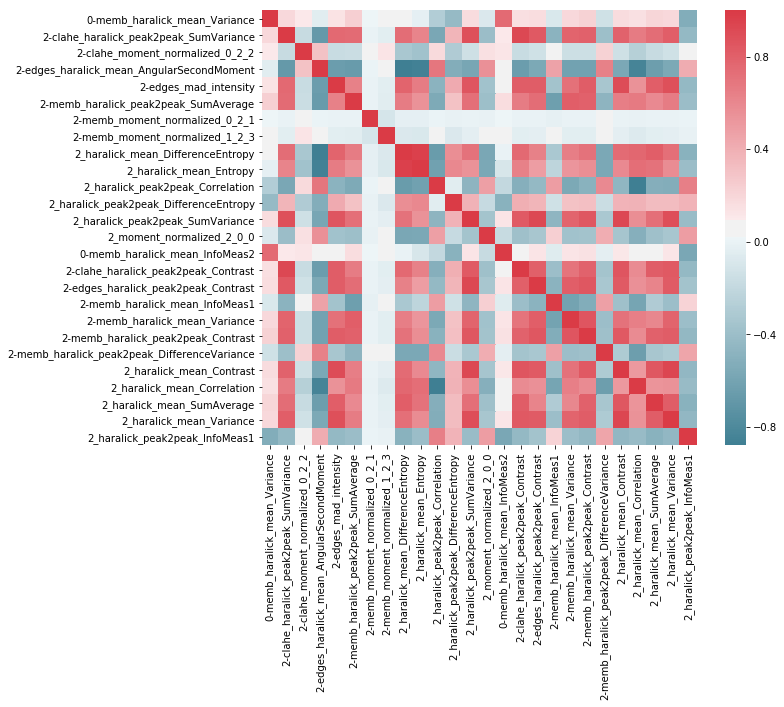

In [51]:
ds.set_features(select_features_by_occurance_count(7).keys())

f, ax = plt.subplots(figsize=(10, 8))
corr = ds.data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Inbanance

In [103]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN


In [24]:
selected = ['0-memb_haralick_mean_Variance', '2-clahe_haralick_peak2peak_SumVariance', '2-clahe_moment_normalized_0_2_2', '2-edges_haralick_mean_AngularSecondMoment', '2-edges_mad_intensity', '2-memb_haralick_peak2peak_SumAverage', '2-memb_moment_normalized_0_2_1', '2-memb_moment_normalized_1_2_3', '2_haralick_mean_DifferenceEntropy', '2_haralick_mean_Entropy', '2_haralick_peak2peak_Correlation', '2_haralick_peak2peak_DifferenceEntropy', '2_haralick_peak2peak_SumVariance', '2_moment_normalized_2_0_0', '0-memb_haralick_mean_InfoMeas2', '2-clahe_haralick_peak2peak_Contrast', '2-edges_haralick_peak2peak_Contrast', '2-memb_haralick_mean_InfoMeas1', '2-memb_haralick_mean_Variance', '2-memb_haralick_peak2peak_Contrast', '2-memb_haralick_peak2peak_DifferenceVariance', '2_haralick_mean_Contrast', '2_haralick_mean_Correlation', '2_haralick_mean_SumAverage', '2_haralick_mean_Variance', '2_haralick_peak2peak_InfoMeas1']

In [16]:
ds.set_features(select_features_by_occurance_count(7).keys())

NameError: name 'select_features_by_occurance_count' is not defined

In [83]:
ds.set_features(selected)

In [28]:
X_res, Y_res = sm.fit_resample(ds.data, ds.data_cls)

In [29]:
X_res.shape, Y_res.shape


((27590, 112), (27590,))

In [31]:
from collections import Counter

In [32]:
Counter(Y_res)

Counter({0: 13795, 1: 13795})

In [33]:
cv_image_results = {}
for cv in cross_val_not_grouped:
    cv_image_results[cv] = cross_validate(models['baseline'], X=X_res, y=Y_res, cv=cross_val_not_grouped[cv], scoring=SCORES_LIST, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

KFold F-score: 0.85 (+/- 0.35), Precision: 0.78 (+/- 0.51), Recall: 0.99 (+/- 0.01)
StratifiedKFold F-score: 0.99 (+/- 0.00), Precision: 0.98 (+/- 0.00), Recall: 1.00 (+/- 0.00)


In [ ]:
def print_scores(classifier_output, test_indexes):
    f1 = sklearn.metrics.f1_score(ds.data_cls[test_indexes], classifier_output)
    prec = sklearn.metrics.precision_score(ds.data_cls[test_indexes], classifier_output)
    recall = sklearn.metrics.recall_score(ds.data_cls[test_indexes], classifier_output)
    print()

In [34]:
images_by_names = list(set(group_by_image(ds.data)))

In [112]:
# sm = SMOTE(sampling_strategy=0.3, k_neighbors=2, random_state=42, n_jobs=-1)
sm = ADASYN(sampling_strategy=0.3, n_neighbors=3,random_state=42, n_jobs=-1)
# BorderlineSMOTE

score = {
    "test_f1": [],
    "test_precision": [],
    "test_recall": [],
}
test_images_no = 2
for index in range(0, len(images_by_names), test_images_no):
    test_images = images_by_names[index:index+test_images_no]
    train_images = list(set(images_by_names).difference(set(test_images)))
    test_indexes = []
    train_indexes = []
    for idx in ds.data.index.get_level_values(0):
        test_indexes.append(True if idx in test_images else False)
        train_indexes.append(True if idx in train_images else False)

    X_res, Y_res = sm.fit_resample(ds.data[train_indexes], ds.data_cls[train_indexes])  
    model = models['baseline'].fit(X_res, Y_res)
#     model = models['baseline'].fit(ds.data[train_indexes], ds.data_cls[train_indexes])
    predicted = model.predict(ds.data[test_indexes])
    
    score["test_f1"].append(sklearn.metrics.f1_score(ds.data_cls[test_indexes], predicted))
    score["test_precision"].append(sklearn.metrics.precision_score(ds.data_cls[test_indexes], predicted))
    score["test_recall"].append(sklearn.metrics.recall_score(ds.data_cls[test_indexes], predicted))
    

In [38]:
cv_image_results = {}
for cv in cross_val_not_grouped:
    cv_image_results[cv] = cross_validate(models['baseline'], X=X_res, y=Y_res, cv=cross_val_not_grouped[cv], scoring=SCORES_LIST, n_jobs=-1)
for name, scores in cv_image_results.items():
    print_scores(name, scores)

KFold F-score: 0.85 (+/- 0.35), Precision: 0.78 (+/- 0.51), Recall: 0.99 (+/- 0.01)
StratifiedKFold F-score: 0.99 (+/- 0.00), Precision: 0.98 (+/- 0.00), Recall: 1.00 (+/- 0.00)


In [97]:
# 1:1
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.62 (+/- 0.23), Precision: 0.52 (+/- 0.29), Recall: 0.79 (+/- 0.14)


In [92]:
# 0.3
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.61 (+/- 0.21), Precision: 0.52 (+/- 0.25), Recall: 0.78 (+/- 0.16)


In [94]:
# 0.1
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.63 (+/- 0.21), Precision: 0.57 (+/- 0.28), Recall: 0.74 (+/- 0.18)


In [85]:
# default 
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.67 (+/- 0.11), Precision: 0.70 (+/- 0.21), Recall: 0.67 (+/- 0.23)


In [102]:
# 0.3 k_naigbors = 2
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.62 (+/- 0.20), Precision: 0.55 (+/- 0.27), Recall: 0.75 (+/- 0.14)


In [105]:
# ADASYN 1:1
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.61 (+/- 0.19), Precision: 0.50 (+/- 0.23), Recall: 0.80 (+/- 0.12)


In [107]:
# ADASYN 0.3
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.60 (+/- 0.21), Precision: 0.50 (+/- 0.26), Recall: 0.80 (+/- 0.12)


In [109]:
# ADASYN 0.1
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.63 (+/- 0.22), Precision: 0.56 (+/- 0.32), Recall: 0.77 (+/- 0.14)


In [111]:
# ADASYN 0.1 neighbours=3
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.63 (+/- 0.21), Precision: 0.56 (+/- 0.30), Recall: 0.75 (+/- 0.18)


In [113]:
# ADASYN 0.3 neighbours=3
for k in score.keys():
    score[k] = np.array(score[k])
print_scores("smote", score)

smote F-score: 0.62 (+/- 0.20), Precision: 0.52 (+/- 0.26), Recall: 0.79 (+/- 0.13)
